# Predspracovanie údajov
### Projekt z predmetu Inteligentná analýza údajov
#### Martin L. Zachar, Štefan Šebeň

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import re



pd.set_option('display.max_columns', 50)

Načítali sme si dátový súbor v stave, v akom sme ho zanechali na konci predchádzajúcej práce, kde sme tiež už čiastočne začali s predspracovaním dát.

In [2]:
train_data = pd.read_csv('data/explorovane.csv', index_col='id')
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,TBG measured,TBG,referral source,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,testID
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,f,NaN,SVI,Local-gov,141649,Assoc-voc,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,991
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,f,NaN,other,Local-gov,177599,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1685
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,f,NaN,other,Self-emp-not-inc,102631,Some-college,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,3504
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,f,NaN,other,private,272338,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1942
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,f,NaN,SVHC,Self-emp-inc,368825,Some-college,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,2009


Zrušili sme stĺpce, ktoré neprispejú ku klasifikácii - TBG measured a TBG nadobúdajú len 1 hodnotu, education má tie isté hodnoty ako education-num a testID je len ďalšie id.

In [3]:
train_data = train_data.drop(['TBG measured', 'TBG', 'education', 'testID'], axis=1)

Najprv sme sa pozreli na problém s formátom dátumu. Identifiikovali sme, aké možné problémy sú vo formáte.

In [4]:
dates = train_data['date_of_birth'].dropna()
dates = list(map(lambda s: re.split(' |-|/|:', s) ,dates))

print("Neidentifikovatelne: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) <= 31, dates))))
print("Rok bez uvodnych cisel: ", len(list(filter(lambda d: int(d[0]) < 1900 and int(d[0]) > 31 and int(d[2]) <= 31, dates))))
print("Vymeneny rok a den: ", len(list(filter(lambda d: int(d[0]) <= 31 and int(d[2]) > 1900, dates))))
print("Zly mesiac: ", len(list(filter(lambda d: int(d[1]) > 12, dates))))
print("S casom dna: ", len(list(filter(lambda d: len(d) > 3, dates))))        

Neidentifikovatelne:  5
Rok bez uvodnych cisel:  189
Vymeneny rok a den:  180
Zly mesiac:  0
S casom dna:  382


Pridali sme nové stĺpce pre rok a mesiac. Istá sezónnosť v rámci mesiacov roka nemusí byť nutne vylúčená (vplyvy počasia a podnebia apod.), podobne mohol mať teoreticky vplyv aj rok narodenia.

In [5]:
train_data['birth_year'] = np.nan
train_data['birth_month'] = np.nan

Dátum sme konvertovali na jednotný formát, či lepšie povedané, z jednotlivých formátov sme extrrahovali do príslušných stĺpcov rok a mesiac narodenia.

In [6]:
for i in range(train_data.shape[0]-1):
    if (pd.isna(train_data.loc[i]['date_of_birth'])):
        continue
    date = list(map(int, re.split(' |-|/|:', train_data.iloc[i]['date_of_birth'])))
    if date[0] <= 31 and date[2] <= 31:
        continue
    elif date[0] <= 31 and date[2] > 31:
        b = date[2]
        date[2] = date[0]
        date[0] = b
    if date[0] < 1900:
        if int(str(date[0])[-2:]) < 18:
            date[0] = date[0] + 2000 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
        else:
            date[0] = date[0] + 1900 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
    if len(date) > 3:
        date = date[:3]
    train_data.loc[i, 'birth_year'] = date[0]
    train_data.loc[i, 'birth_month'] = date[1]

Mesiac narodenia sme konvertovali na kategorický atribút, pretože i keď sa dá vyjadriť číselne a aj vzdialenosť (rozdiel) medzi jednotlivými hodnotami má význam, mesiace sú cyklické, s čím by algoritmi pre číselné atribúty nepočítali.

In [7]:
train_data['birth_month'] = train_data['birth_month'].astype(str)
for i in range(train_data.shape[0]):
    if train_data.loc[i,'birth_month'] == 'nan':
        train_data.loc[i,'birth_month'] = '?'
train_data.head()

,age,on thyroxine,query on thyroxine,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,hypopituitary,TSH,T3 measured,T3,TT4,T4U,FTI measured,referral source,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,date_of_birth,TSH measured,sex,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,test,birth_year,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,82.0,f,f,f,f,f,f,f,f,f,2.2,t,1.0,68.0,0.77,t,SVI,Local-gov,141649,11,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States,1935-05-20 00:00:00,t,M,f,t,f,88.0,f,t,f,f,negative,1935.0,5.0
1,50.0,f,f,f,t,f,f,f,f,f,76.0,t,0.5,22.0,1.12,t,other,Local-gov,177599,13,Divorced,Prof-specialty,Unmarried,White,0,0,35,United-States,67-08-03,t,F,f,t,f,19.0,f,t,f,f,negative,1967.0,8.0
2,41.0,f,f,f,f,f,f,f,f,f,NaN,t,2.0,99.0,0.96,t,other,Self-emp-not-inc,102631,10,Widowed,Farming-fishing,Unmarried,White,0,0,50,United-States,1976-05-02,f,F,f,t,f,104.0,f,t,f,f,negative,1976.0,5.0
3,73.0,f,f,f,f,f,f,f,f,f,0.7,t,2.0,116.0,0.99,t,other,private,272338,9,Married-civ-spouse,Adm-clerical,Wife,White,0,0,25,United-States,44-10-08,t,F,f,t,f,117.0,f,t,f,f,negative,1944.0,10.0
4,64.0,f,f,f,f,f,f,f,f,f,2.0,t,1.8,80.0,0.91,t,SVHC,Self-emp-inc,368825,10,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1953-05-01,t,M,f,t,f,88.0,f,t,f,f,negative,1953.0,5.0


Stĺpec date_of_birth sme už viac nepotrebovali, tak sme ho zahodili.

In [8]:
train_data = train_data.drop(['date_of_birth'], axis=1)

Overili sme si, či sa nám správne podarilo preložiť rok a mesiac z jednotlivých formátov.

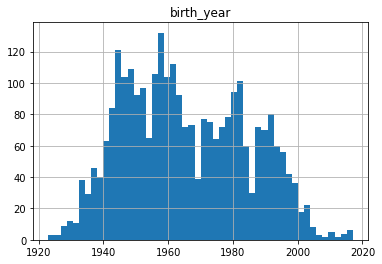

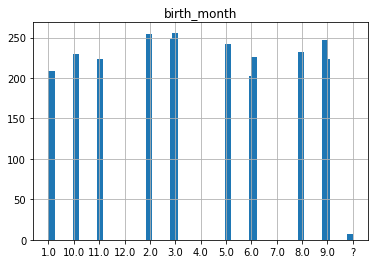

In [9]:
pd.Series(train_data['birth_year']).hist(bins=50).set_title("birth_year")
plt.figure()
pd.Series(train_data['birth_month']).hist(bins=50).set_title("birth_month")
plt.figure()

Zkúčili sme rozdielne zapísané hodnoty atribútov s totožným významom. Preistotu sme aj z hodnoty každého kategorického atribútu odstránili biele znaky a skonvertovali na malé písmená.

In [10]:
for i in range(train_data.shape[0]):
    if train_data.loc[i, 'on thyroxine'] == 'FALSE' or train_data.loc[i, 'on thyroxine'] == 'F':
        train_data.loc[i, 'on thyroxine'] = 'f'
    elif train_data.loc[i, 'on thyroxine'] == 'TRUE' or train_data.loc[i, 'on thyroxine'] == 'T':
        train_data.loc[i, 'on thyroxine'] = 't'
    
    for col in train_data.columns[train_data.dtypes == np.object]:
        if pd.notna(train_data.loc[i, col]):
            train_data.loc[i, col] = train_data.loc[i, col].lower().strip().replace("-", "_")

Pozreli sme sa, či sa nám úspešne podaril ozlúčiť všetky hodnoty. Áno.

In [11]:
for column in train_data.columns[train_data.dtypes == np.object]:
    if train_data[column].unique().size < 50:
        print(train_data[column].value_counts())
        print()

f    2470
t     330
Name: on thyroxine, dtype: int64

f    2760
t      40
Name: query on thyroxine, dtype: int64

f    2759
t      41
Name: pregnant, dtype: int64

f    2761
t      39
Name: thyroid surgery, dtype: int64

f    2752
t      48
Name: I131 treatment, dtype: int64

f    2786
t      14
Name: lithium, dtype: int64

f    2775
t      25
Name: goitre, dtype: int64

f    2729
t      71
Name: tumor, dtype: int64

f    2799
t       1
Name: hypopituitary, dtype: int64

t    2215
f     585
Name: T3 measured, dtype: int64

t    2505
f     295
Name: FTI measured, dtype: int64

other    1632
svi       771
svhc      275
stmw       91
svhd       31
Name: referral source, dtype: int64

private             1974
local_gov            212
self_emp_not_inc     178
?                    169
state_gov            123
federal_gov           75
self_emp_inc          69
Name: workclass, dtype: int64

never_married            1118
married_civ_spouse        853
divorced                  489
widowed       

# 2 Nahrádzanie odľahlých hodnôt

Najprv sme si pripravili funkciu na nahradzovanie stĺpca dátového súboru jeho trnasformáciou pomocou box-cox algoritmu. Táto funckia počíta s tým, že stĺpec môže obsahovať ešte neznáme hodnoty. Urobili sme tomu tak preto, aby sme nemusili dopĺňať neznáme hodnoty ešte predtým, než nahradíme odľahlé hodnoty, ktoré môžu ovplyvniť nahradzované hodnoty.

Rovnako sme si predpripravili aj funkcie na nájrádzanie odľahlých hodnôt.

In [12]:
from scipy.stats import boxcox
from functools import reduce

def replaceWithBC(data, attr):
    bc, att = boxcox(data[attr].dropna())
    i2 = 0
    for i in range(data.shape[0]):
        if pd.notna(data.loc[i, attr]):
            data.loc[i, attr] = bc[i2]
            i2 = i2 + 1
    data.rename(index=str, columns={attr: attr + "_(box_cox)"})
            
def replaceOutliers(data, attr, thrshl, new):
    for i in range(data.shape[0]):
        if thrshl(data.loc[i, attr]):
            data.loc[i, attr] = new
            
def replaceOutliersD(data, attr, thrshl, new):
    for i in range(data.shape[0]):
        if thrshl(data.loc[i, attr]):
            data.loc[i, attr] = new(data.loc[i])

Pripravili sme si slovník do ktorého sa zapíše unikátnosť hodnôt jednotlivých atribútov. Toto budeme využívať pri dodatočnej identifikácii outlierov...

In [13]:
uniquenesstable = {}
def updateUniquenesstable():
    for column in train_data.columns[train_data.dtypes == np.object]:
        unique = train_data[column].unique()
        uniquenesstable[column] = {}
        for u in unique:
            uniquenesstable[column][u] = len(train_data[train_data[column] == u][column]) / len(train_data[column])
        uniquenesstable[column]['expected'] = 1 / len(unique)

    for column in train_data.columns:
        if np.issubdtype(train_data[column].dtype, np.number):
            uniquenesstable[column] = {}
            uniquenesstable[column]['mean'] = train_data[column].mean()
            uniquenesstable[column]['median'] = train_data[column].median()
            uniquenesstable[column]['std'] = train_data[column].std()
            
updateUniquenesstable()

... a taktiež aj funkciu, ktorá tieto unikátne hodnoty vypíše.

In [14]:
def printUnique(data, attr, f):
    outs = data[f(data[attr])]
    c = 0
    for i in range(outs.shape[0]):
        un = False
        for col in data.columns:
            out = outs.iloc[i]
            if not pd.isna(out[col]):
                if np.issubdtype(train_data[col].dtype, np.number):
                    if out[col] < uniquenesstable[col]['mean'] - uniquenesstable[col]['std'] or out[col] > uniquenesstable[col]['mean'] + uniquenesstable[col]['std']:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col]['mean'])
                        un = True
                    elif out[col] < uniquenesstable[col]['median'] - uniquenesstable[col]['std'] or out[col] > uniquenesstable[col]['median'] + uniquenesstable[col]['std']:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col]['median'])
                        un = True
                else:
                    if uniquenesstable[col][out[col]] < uniquenesstable[col]['expected'] / 2:
                        print(i, attr, out[attr], col, out[col], uniquenesstable[col][out[col]], uniquenesstable[col]['expected'])
                        un = True
        if (un):
            c = c + 1
    print("Unikátnych", c, "z", outs.shape[0])

Pomohli sme si aj korelačnou tabuľkou, ktorú sme prevzali z prechádzajúceho dokumentu.

age - T3  correlation:  -0.24237972891474738
age - birth_year  correlation:  -0.9211649983991632
TSH - TT4  correlation:  -0.2685525331664122
TSH - FTI  correlation:  -0.291188373868199
T3 - TT4  correlation:  0.5660571765652239
T3 - T4U  correlation:  0.46343405909602275
T3 - FTI  correlation:  0.3510133883173405
T3 - birth_year  correlation:  0.2686637335777969
TT4 - T4U  correlation:  0.4339389434445414
TT4 - FTI  correlation:  0.798007458309882


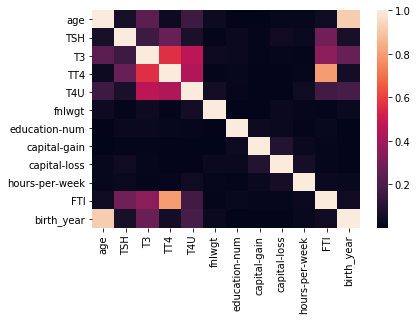

In [15]:
for i in range(train_data.shape[1]):
    if np.issubdtype(train_data[train_data.columns[i]].dtype, np.number):
        for i2 in range(i, train_data.shape[1]):
            if np.issubdtype(train_data[train_data.columns[i2]].dtype, np.number):
                corr = train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and train_data.columns[i] != train_data.columns[i2]:
                    print(train_data.columns[i], "-", train_data.columns[i2], " correlation: ", train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]]))

corr = train_data.corr()
seaborn.heatmap(abs(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

TSH malo distribúciu hodnôt pomerne značne roztiahnutú do jednej strany, avšak boli možné pozorovať náznaky toho, že sa snaží mať normálnu distribúciu. Použijeme teda box-cox, aby sme sa pokúsili túto normálnu distriúciu dosiahnúť. 

Po úprave pomocou box-cox algoritmu sú viditeľne hodnoty koncentrovanejšie ako pri neupravovnom atribúte a aj symetrickejšie. Je však možné aj vidieť, že úplná normálna distribúcia dosiahnutá nebola a stále sú hodnoty na ľavej strane od vrcholu distribúcie viac hustejšie naukladané ako na pravej strane, čomu bolo rovnako aj pri pôvodnej distribúcii. Nahradíme teda atribút TSH jeho box-cox verziou a atribút aj patrične premenujeme.

In [16]:
bc, att = boxcox(train_data['TSH'].dropna())
print("Skewness TSH orig: ", stats.skew(train_data['TSH'].dropna()))
print("Skewness TSH box-cox: ", stats.skew(bc))
print("Kurtosis TSH orig: ", stats.kurtosis(train_data['TSH'].dropna()))
print("Kurtosis TSH box-cox: ", stats.kurtosis(bc))

Skewness TSH orig:  14.824564019675963
Skewness TSH box-cox:  0.05058391985348052
Kurtosis TSH orig:  284.54408349616324
Kurtosis TSH box-cox:  1.2940121811098484


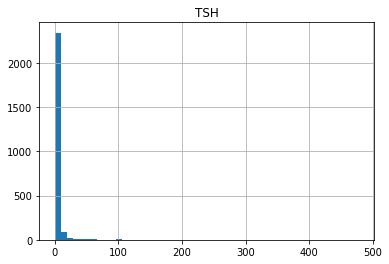

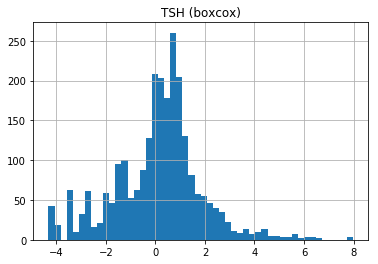

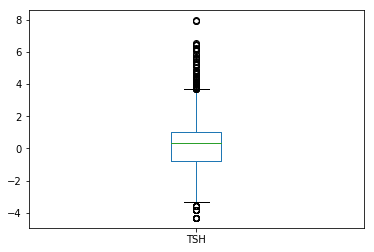

In [17]:
pd.Series(train_data['TSH']).hist(bins=50).set_title("TSH")
plt.figure()
replaceWithBC(train_data, 'TSH')
pd.Series(train_data['TSH']).hist(bins=50).set_title("TSH (boxcox)")
plt.figure()
pd.Series(train_data['TSH']).plot(kind='box')
plt.figure()

updateUniquenesstable()

Vidíme, že subjekty s nameraným vysokým TSH majú zároveň aj pomerne nízke FTI a TT4, čo je možné povšimnúť si aj v korelačnej tabuľke. Keby sme teda tieto domnelo vychýlené hodnoty upravili či odstránili, mohli by sme oslabiť koreláciu týchto atribútov. Nebudeme teda považovať žiadne hodnoty TSH za vychýlené.

In [18]:
printUnique(train_data, 'TSH', lambda x: x > 7.9)

0 TSH 7.970062271875442 age 18.0 51.79356887653831
0 TSH 7.970062271875442 on thyroxine t 0.11785714285714285 0.5
0 TSH 7.970062271875442 TSH 7.970062271875442 0.12403982275038332
0 TSH 7.970062271875442 T3 measured f 0.20892857142857144 0.5
0 TSH 7.970062271875442 T4U 1.3 0.9979121054734323
0 TSH 7.970062271875442 workclass federal_gov 0.026785714285714284 0.14285714285714285
0 TSH 7.970062271875442 relationship other_relative 0.03678571428571428 0.16666666666666666
0 TSH 7.970062271875442 FTI 34.0 110.78798403193613
0 TSH 7.970062271875442 birth_year 1999.0 1965.5130683852487
1 TSH 7.949412739416855 age 2.0 51.79356887653831
1 TSH 7.949412739416855 TSH 7.949412739416855 0.12403982275038332
1 TSH 7.949412739416855 TT4 34.0 108.99039115646256
1 TSH 7.949412739416855 referral source stmw 0.0325 0.2
1 TSH 7.949412739416855 marital-status married_spouse_absent 0.01892857142857143 0.14285714285714285
1 TSH 7.949412739416855 native-country columbia 0.0025 0.02631578947368421
1 TSH 7.9494127

T3 nebudeme nahradzovať s box-cox, k normalizácii jeho distribúcie by to výrazne neprispelo. Overíme si však, či podozrivá hodnota nad 10 nie je vychýlenou hodnotou.

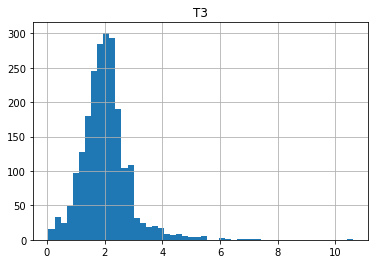

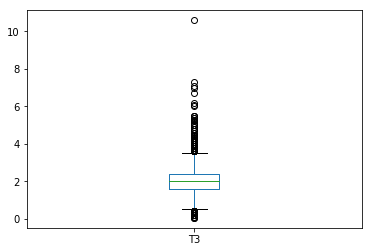

In [19]:
pd.Series(train_data['T3']).hist(bins=50).set_title("T3")
plt.figure()
pd.Series(train_data['T3']).plot(kind='box')
plt.figure()

Vskutku sa zdá, že táto hodnota môže byť valídna, vzhľadom na extrémne hodnoty namerané i u ostatných atribútov. Zistenie potvrdzuje i korelačná tabuľka. Nebudeme s ňou manipulovať z rovnakých dôvodov, ako sme uviedli pri TSH.

In [20]:
printUnique(train_data, 'T3', lambda x: x > 10)

0 T3 10.6 age 77.0 51.79356887653831
0 T3 10.6 TSH -3.568818698884796 0.12403982275038332
0 T3 10.6 T3 10.6 2.024966139954856
0 T3 10.6 TT4 226.0 108.99039115646256
0 T3 10.6 T4U 0.65 0.9979121054734323
0 T3 10.6 FTI 349.0 110.78798403193613
0 T3 10.6 birth_year 1940.0 1965.5130683852487
Unikátnych 1 z 1


Nezdá sa, že by distribúciu TT4 bolo nutné upravovať. Overíme si odľahlé hodnoty nad 400.

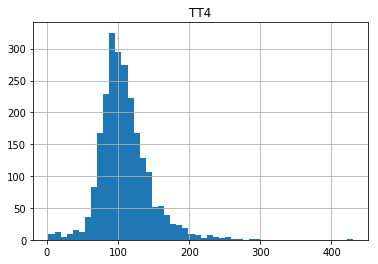

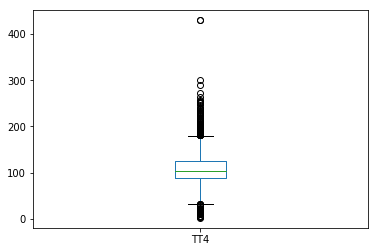

In [21]:
pd.Series(train_data['TT4']).hist(bins=50).set_title("TT4")
plt.figure()
pd.Series(train_data['TT4']).plot(kind='box')
plt.figure()

Ani tieto hodnoty nie sú samé, ktoré sa zdajú byť odľahlé. Je teda pravdepodobnejšie, že sú valídne. Korelačná tabuľka tvrdí to isté.

In [22]:
printUnique(train_data, 'TT4', lambda x: x > 400)

0 TT4 430.0 pregnant t 0.014642857142857143 0.5
0 TT4 430.0 TSH -1.5104393060023016 0.3410268735877535
0 TT4 430.0 T3 measured f 0.20892857142857144 0.5
0 TT4 430.0 TT4 430.0 108.99039115646256
0 TT4 430.0 referral source stmw 0.0325 0.2
0 TT4 430.0 fnlwgt 46401 185980.77535714285
0 TT4 430.0 query hyperthyroid t 0.061785714285714284 0.5
0 TT4 430.0 FTI 395.0 110.78798403193613
1 TT4 430.0 TSH -1.7605906784915695 0.12403982275038332
1 TT4 430.0 T3 7.3 2.024966139954856
1 TT4 430.0 TT4 430.0 108.99039115646256
1 TT4 430.0 referral source stmw 0.0325 0.2
1 TT4 430.0 query hyperthyroid t 0.061785714285714284 0.5
1 TT4 430.0 FTI 395.0 110.78798403193613
Unikátnych 2 z 2


Pri T4U sa nenachádza hodnota, ktorú by sme vizuálne zhodnotili za odľahlú, distribúcia je pomerne súvislá, upravovať ju nebudeme.

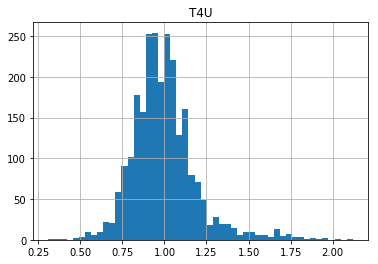

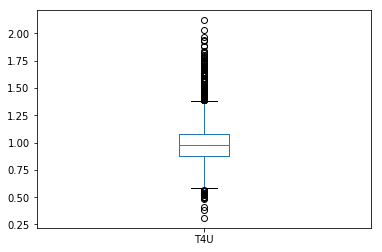

In [23]:
pd.Series(train_data['T4U']).hist(bins=50).set_title("T4U")
plt.figure()
pd.Series(train_data['T4U']).plot(kind='box')
plt.figure()

Pri FTI by sa použitím box-cox taktiež distribúcia priveľmi nepopravila bližšie k normálnej. Vyskúšame, či hodnoty nad 270 nie sú odľahlé.

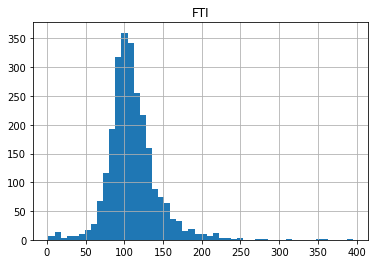

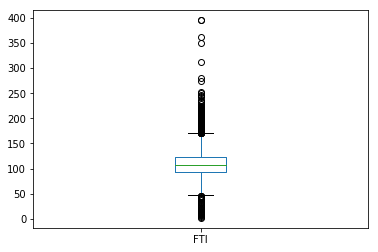

In [24]:
pd.Series(train_data['FTI']).hist(bins=50).set_title("FTI")
plt.figure()
pd.Series(train_data['FTI']).plot(kind='box')
plt.figure()

Aj u FTI je možné pozorovať, že zdanlivo odľahlé hodnoty sa konzistentne upravujú podľa zistených korelácií. Nebudeme ich meniť.

In [25]:
printUnique(train_data, 'FTI', lambda x: x > 270)

0 FTI 274.0 TSH -3.854253878097603 0.12403982275038332
0 FTI 274.0 T3 5.5 2.024966139954856
0 FTI 274.0 TT4 219.0 108.99039115646256
0 FTI 274.0 T4U 0.8 0.9979121054734323
0 FTI 274.0 workclass state_gov 0.04392857142857143 0.14285714285714285
0 FTI 274.0 fnlwgt 19395 185980.77535714285
0 FTI 274.0 query hyperthyroid t 0.061785714285714284 0.5
0 FTI 274.0 FTI 274.0 110.78798403193613
1 FTI 395.0 pregnant t 0.014642857142857143 0.5
1 FTI 395.0 TSH -1.5104393060023016 0.3410268735877535
1 FTI 395.0 T3 measured f 0.20892857142857144 0.5
1 FTI 395.0 TT4 430.0 108.99039115646256
1 FTI 395.0 referral source stmw 0.0325 0.2
1 FTI 395.0 fnlwgt 46401 185980.77535714285
1 FTI 395.0 query hyperthyroid t 0.061785714285714284 0.5
1 FTI 395.0 FTI 395.0 110.78798403193613
2 FTI 349.0 age 77.0 51.79356887653831
2 FTI 349.0 TSH -3.568818698884796 0.12403982275038332
2 FTI 349.0 T3 10.6 2.024966139954856
2 FTI 349.0 TT4 226.0 108.99039115646256
2 FTI 349.0 T4U 0.65 0.9979121054734323
2 FTI 349.0 FTI 349

Distribúcia atribútu fnlwgt pôsobí "useknuto" a na jednej strane rozťahane. Pokúsime sa ju znormalizovať pomocou box-cox algoritmu.

Použitie box-cox viditeľne pomohlo zosymetrizovať distribúciu atribútu fnlwgt, podobne však ako u TSH sa nepodarilo dosiahnúť úplnú symetricitu, či normálne rozdelenie. Hodnoty sú však aj značne koncentrovanejšie a keďže hodnoty atribútu fnlwgt ani nemajú nejakú výraznú výpovednú hodnotu, nebude škodiť, keď fnwgt nahradíme box-cox verziou. 

Bližšie sa pozrieme na hodnoty s váhou vyššou ako 720.

In [26]:
print("Skewness fnlwgt orig: ", stats.skew(train_data['fnlwgt'].dropna()))
print("Skewness fnlwgt box-cox: ", stats.skew(bc))
print("Kurtosis fnlwgt orig: ", stats.kurtosis(train_data['fnlwgt'].dropna()))
print("Kurtosis fnlwgt box-cox: ", stats.kurtosis(bc))

Skewness fnlwgt orig:  1.4582578636301344
Skewness fnlwgt box-cox:  0.05058391985348052
Kurtosis fnlwgt orig:  5.76294202332816
Kurtosis fnlwgt box-cox:  1.2940121811098484


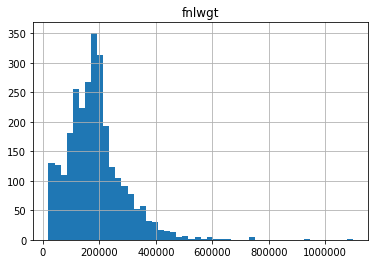

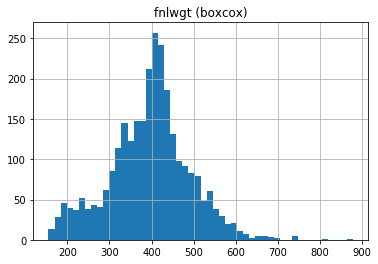

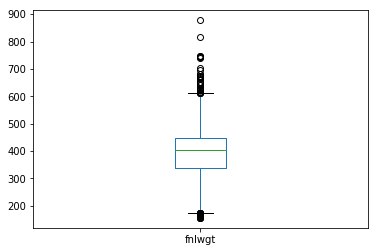

In [27]:
pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt")
plt.figure()
replaceWithBC(train_data, 'fnlwgt')
pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt (boxcox)")
plt.figure()
pd.Series(train_data['fnlwgt']).plot(kind='box')
plt.figure()

updateUniquenesstable()

I keď takmer každá z týchto vysokých hodnôt fnlwgt má nejaký iný atribút pomerne unikátny, nie je tu vidieť nijaká konzistencia, t.j. že niektorý z iných atribútov je pri každej z týchto hodnôt atribútu fnlwgt výnimočný. Odpovedá to zisteniam z prieskumnej analýzy, kde sme zistili najviac chabú súvislosť s atribptmi race, occupation a marital-status, pričom ani tieto nefigurujú vo vyššom počte v nižšie uvedenom výpise unikátnosti hodnôt. 

Všetko toto spolu značí, že s vysokou pravdepodobnosťou možno upraviť tieto odľahlé hodnoty bez výrazného dopadu na prípadné korelácie tohto atribútu s inými. Použijeme pritom stratégiu nahradzovaním 95-percentným kvartilom, keďže táto sa nám zdá byť sympatickejšia voči odstraňovaniu. Odstránenie by však taktiež nebolo veľkým krokom vedľa, pretože žiadne z uvedených pozorovaní nie je oslňujúco unikátne svojimi hodnotami a ani nesúvisí s atribútom, voči ktorému budeme klasifikovať.

In [28]:
printUnique(train_data, 'fnlwgt', lambda x: x > 720)

0 fnlwgt 745.5596830514392 T3 measured f 0.20892857142857144 0.5
0 fnlwgt 745.5596830514392 fnlwgt 745.5596830514392 395.8140939185308
0 fnlwgt 745.5596830514392 FTI 73.0 110.78798403193613
0 fnlwgt 745.5596830514392 query hypothyroid t 0.05821428571428571 0.5
1 fnlwgt 740.520637388126 age 74.0 51.79356887653831
1 fnlwgt 740.520637388126 T4U 0.8 0.9979121054734323
1 fnlwgt 740.520637388126 fnlwgt 740.520637388126 395.8140939185308
1 fnlwgt 740.520637388126 FTI 152.0 110.78798403193613
1 fnlwgt 740.520637388126 birth_year 1943.0 1965.5130683852487
2 fnlwgt 744.158996157952 T3 measured f 0.20892857142857144 0.5
2 fnlwgt 744.158996157952 FTI measured f 0.10535714285714286 0.5
2 fnlwgt 744.158996157952 fnlwgt 744.158996157952 395.8140939185308
2 fnlwgt 744.158996157952 occupation tech_support 0.030714285714285715 0.07142857142857142
2 fnlwgt 744.158996157952 hours-per-week 15 38.33642857142857
2 fnlwgt 744.158996157952 TSH measured f 0.10142857142857142 0.5
2 fnlwgt 744.158996157952 TT4 me

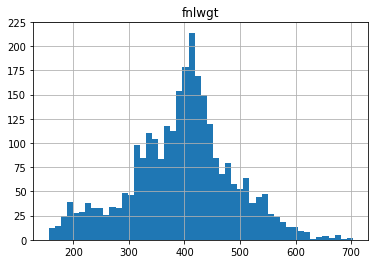

In [29]:
replaceOutliers(train_data, 'fnlwgt', lambda a: a > 720, np.percentile(train_data['fnlwgt'], 95))

pd.Series(train_data['fnlwgt']).hist(bins=50).set_title("fnlwgt")
plt.figure()

Pri hourse-per-week sa pozrieme na subjekty na ostrovčeku s viac ako 95 hodinami za týždeň. Podozrivé sa môžu síce zdať už aj hodnoty nad 60, alebo pod 10, avšak iba tieto hodnoty nad 95 sú výzarne odtrhnuté od ostatných a od chvostov distribúcie.

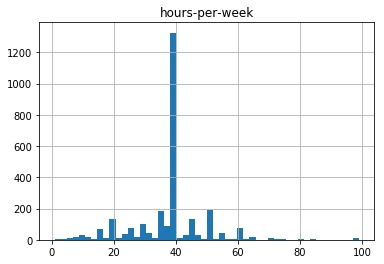

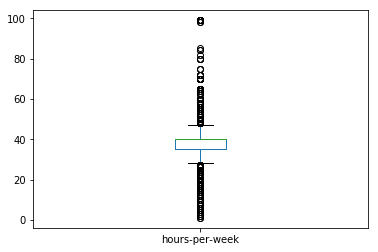

In [30]:
pd.Series(train_data['hours-per-week']).hist(bins=50).set_title("hours-per-week")
plt.figure()
pd.Series(train_data['hours-per-week']).plot(kind='box')
plt.figure()

Pri vysokých hodnotách počtu hodín za týždeň sa jedná prevažne o samozamestaných ľudí, pričom niektorí majú podozrivo vysoký vek vzhľadom na počet odpracovaných hodín. Niektorí majú aj odchýlené niektoré medicínske merania, sú však odchýlené nekonzistentne, takže sa o súvis nejedná - žiaden ani nebol odhalený pri prieskumnej analýze.

Týchto jedenásť hodnôt nahradíme teda 95-percentilom. Opäť, ako pri atribúte fnlwgt, nie je tu žiadna hodnota, ktorá by mala výsledok testu (atribút voči ktorému budeme klasifikovať) nezhodný (tá vzácnejšia hodnota klasifikovaného atribútu), avšak tri či štyry z týchto pozorovaní majú pomerne vysoké namerané hodnoty niektorých z medicínskych meraní, takže by ich možno bolo škoda stratiť odstránením týchto subjektov z dátového súboru.

In [31]:
printUnique(train_data, 'hours-per-week', lambda x: x > 85)

0 hours-per-week 99 T3 measured f 0.20892857142857144 0.5
0 hours-per-week 99 hours-per-week 99 38.33642857142857
0 hours-per-week 99 birth_year 1990.0 1965.5130683852487
1 hours-per-week 98 workclass self_emp_not_inc 0.06357142857142857 0.14285714285714285
1 hours-per-week 98 fnlwgt 507.3428746196795 395.8140939185308
1 hours-per-week 98 occupation farming_fishing 0.021785714285714287 0.07142857142857142
1 hours-per-week 98 hours-per-week 98 38.33642857142857
2 hours-per-week 99 on thyroxine t 0.11785714285714285 0.5
2 hours-per-week 99 workclass federal_gov 0.026785714285714284 0.14285714285714285
2 hours-per-week 99 fnlwgt 535.2953540287214 395.8140939185308
2 hours-per-week 99 hours-per-week 99 38.33642857142857
3 hours-per-week 99 TSH -2.1035561988941174 0.12403982275038332
3 hours-per-week 99 T3 measured f 0.20892857142857144 0.5
3 hours-per-week 99 TT4 62.0 108.99039115646256
3 hours-per-week 99 fnlwgt 537.4541713946792 395.8140939185308
3 hours-per-week 99 occupation farming_fi

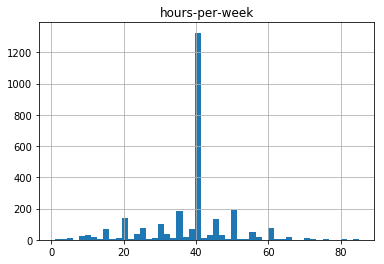

In [32]:
replaceOutliers(train_data, 'hours-per-week', lambda a: a > 95, np.percentile(train_data['hours-per-week'], 95))

pd.Series(train_data['hours-per-week']).hist(bins=50).set_title("hours-per-week")
plt.figure()

Vek s hodnotou 455 rokov je bezpochyby odľahlou hodnotou uvažujúc, že nie je možné sa takého vysokého veku dožiť. Preskúmanie unikátnych hodnôt tohto pozorovania ukázalo, že sa nelíši ničím inakším zvláštnym len samotným vekom. Pri troche nápaditosti si možno domyslieť, že sa vzhľadom na rok narodenia 1962 pozorovania má jednať o vek 55 rokov, takže je túto odľahlú hodnotu ľahké opraviť. V tomto prípade by však ani odstránenie pozorovania neuškodilo, kedže neobsahuje unikátne hodnoty.

In [33]:
printUnique(train_data, 'age', lambda x: x == 455)

0 age 455.0 age 455.0 51.79356887653831
0 age 455.0 workclass state_gov 0.04392857142857143 0.14285714285714285
Unikátnych 1 z 1


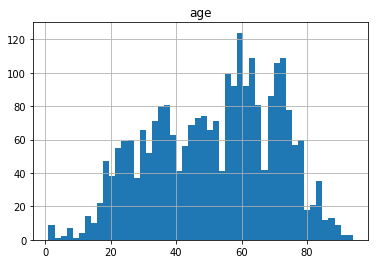

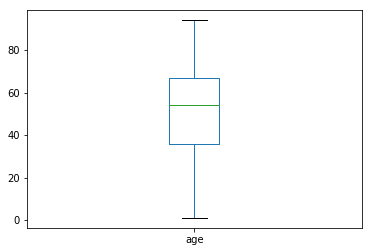

In [34]:
replaceOutliersD(train_data, 'age', lambda a: a > 100, lambda a: 2017 - a.birth_year)
pd.Series(train_data['age']).hist(bins=50).set_title("age")
plt.figure()
pd.Series(train_data['age']).plot(kind='box')
plt.figure()

Keďže už máme dátum narodenia v číselnej podobe a v atribúte vek sme odstránili odľahlú hodnotu, môžeme si overiť aj to, či sa merania odkazujú na rovnaký dátum.

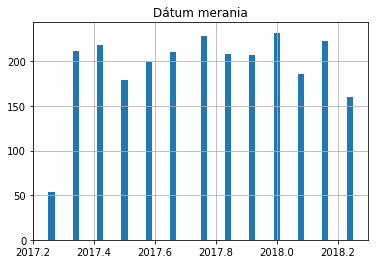

In [35]:
currDate = train_data.birth_year.copy()
for i in range(len(currDate)):
    currDate.loc[i] = currDate.loc[i] + train_data.age.loc[i]
    currDate.loc[i] = currDate.loc[i] + ((float(train_data.birth_month.loc[i]) / 12) if train_data.birth_month.loc[i] != '?' else 0)

pd.Series(currDate).hist(bins=50).set_title("Dátum merania")
plt.figure()

Zjednotíme rozličné hodnoty edukačného čísla s rovnakým významom. Edukačné číslo budeme používať namiesto samotného kategorického atribútu "education", ktorý sme odstránili.

In [36]:
for i in range (len(train_data['education-num'])):
    if train_data.loc[i, 'education-num'] < 0:
        train_data.loc[i, 'education-num'] *= -1
    if train_data.loc[i, 'education-num'] >= 100:
        train_data.loc[i, 'education-num'] = train_data.loc[i, 'education-num']/100

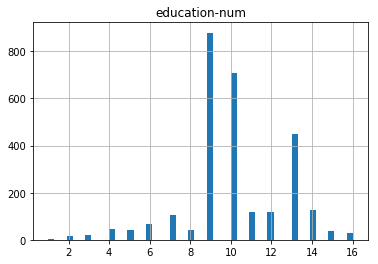

In [37]:
pd.Series(train_data['education-num']).hist(bins=50).set_title("education-num")
plt.figure()

Atribúty capital-gain a capital-loss mali distribúciu, ktorú nebolo možné napraviť do normálnej distribúcie a ani ju prehlásiť za nejakú inú, známu distribúciu. Taktiež viac ako 90 percent hodnôt týchto číslených atribútov nadobúdalo hodnotu 0, žo značí že buď nebola hodnota meraná, alebo pozorovania ani žiadnú takú aktivitu, ktorá by viedla k zmene ich kapitálu nevykazovali. Keďže v takejto podobe nemajú tieto atribúty žiaden pozorovateľný vplyv na ostatné hodnoty dátového súboru, rozhodli sme sa pokúsiť ešte tento atribút upraviť na atribút kategorický, ktorý by nadobúdal tri hodnoty, vyjadrujúce či doľlo k prírastku, úbytku kapirálu, alebo sa kapitál nezmenil. Je možné, že u takto zlúčených hodnotách bude možno nejaký súvis s hodnotami ostatnými atribútov pozorovať.

In [38]:
train_data['yield'] = np.nan
for i in range(train_data.shape[0]):
    yld = train_data.loc[i,'capital-gain'] - train_data.loc[i, 'capital-loss']
    if (yld == 0):
        train_data.loc[i, 'yield'] = 'none'
    elif (yld < 0):
        train_data.loc[i, 'yield'] = 'loss'
    else:
        train_data.loc[i, 'yield'] = 'gain'

In [39]:
train_data = train_data.drop(['capital-gain', 'capital-loss'], axis=1)

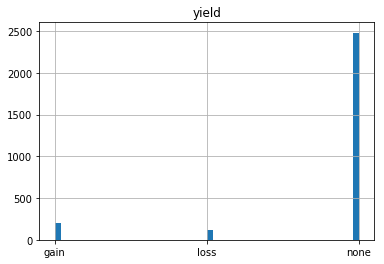

In [40]:
pd.Series(train_data['yield']).hist(bins=50).set_title("yield")
plt.figure()

# 3 Odhadovanie neznámych hodnôt
## 3.1 Číselné atribúty

Neznáme hodnoty číselných atribútov sme sa pokúsili nahradiť priemerom, respektíve mediánom hodnôt daného atribútu.

In [41]:
import math

mean_med = train_data.copy()

for column in mean_med.columns:
    if np.issubdtype(mean_med[column].dtype, np.number):
        if mean_med[column].std() / mean_med[column].mean() <= 1:
            mean = mean_med[column].mean()
            for i in range(len(mean_med[column])):
                if (np.isnan(mean_med.loc[i, column])):
                    mean_med.loc[i, column] = mean
        else:
            median = mean_med[column].median()
            for i in range(len(mean_med[column])):
                if (np.isnan(mean_med.loc[i, column])):
                    mean_med.loc[i, column] = median

for i in range(mean_med.shape[0]):
    mean_med.loc[i, 'birth_year'] = math.ceil(mean_med.loc[i, 'birth_year'])

O to isté sme sa pokúsili aj využitím lineárnej regresie. Museli sme pritom ale použiť pre necieľové stĺpce aj neznáme hodnoty nahradené priemerom/mediánom vo vyššej bunke, pretože regresia nedokáže pracovať s neznámymi hodnotami a niektoré pozorovania v dátovom súbore obsahujú viac neznámych pozorovaní. Nahradenie týchto priemerom/mediánom sa nám zdalo ako riešenie, ktoré najmenej ovplyvňuje a poškodzuje výsledok regresie.

Je možné si povšimnúť, že lineárny model sa najlepšie natrénoval pre atribúty vek, TT4, T4U, FTI a rok narodenia, pri mesiaci narodenia sa ešte drží na ako-takej úrovni, ale pre TSH, T3, fnlwgt, hours-per-week a education-num je už presnosť značne nízka a lineárna predikcia pre ne je prakticky nepoužiteľná.

In [42]:
import sklearn.linear_model
import sklearn.model_selection

linreg = train_data.copy()
numericOnly = pd.DataFrame()
scores = {}

for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        numericOnly[col] = train_data[col].dropna()

for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        numericOnly = numericOnly.dropna()
        X = numericOnly
        y = numericOnly[col]
        X = X.drop(col, axis=1)
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
        
        reg = sklearn.linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        print("Presnosť pre", col, ":", reg.score(X_test, y_test))
        
        scores[col] = reg.score(X_test, y_test)
        
        notknown = pd.DataFrame()
        for col2 in train_data.columns:
            if np.issubdtype(train_data[col2].dtype, np.number):
                #kvôli neznámym hodnotam v necieľových stĺpcoch musíme použiť odhad neznámych dohnôt priemerom/mediánom
                notknown[col2] = mean_med[col2]
            if col2 == col:
                #iba pre cieľový stĺpec vyberáme dáta z pôvodného súboru, kde sú stále aj neznáme hodnoty
                notknown[col2] = train_data[col2]
        
        notknown = notknown[pd.isna(notknown[col])]
        if (notknown.shape[0] == 0):
            continue
            
        X = notknown
        y = notknown[col]
        X = X.drop(col, axis=1)
                
        y = reg.predict(X)
        
        #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými lineárnou regresiou
        i2 = 0
        for i in range(linreg.shape[0]):
            if (pd.isna(linreg.loc[i, col])):
                linreg.loc[i, col] = y[i2]
                i2 = i2 + 1

for i in range(mean_med.shape[0]):
    linreg.loc[i, 'birth_year'] = math.ceil(linreg.loc[i, 'birth_year'])

Presnosť pre age : 0.9995117493367058
Presnosť pre TSH : 0.23137369748602465
Presnosť pre T3 : 0.5295122726402375
Presnosť pre TT4 : 0.9709760114222297
Presnosť pre T4U : 0.9404973657931729
Presnosť pre fnlwgt : -0.013440934248415857
Presnosť pre education-num : 0.005844781577686309
Presnosť pre hours-per-week : 0.006695141143231442
Presnosť pre FTI : 0.9615590681624026
Presnosť pre birth_year : 0.9994404801311224


Odhady zistené pomocou priemeru/mediánu a lineárnou regresiou sme si navzájom porovnali. 

Je možné pozorovať, že nahradzovanie priemerom/mediánom pri atribútoch, ktoré dosahovali viac neznámych hodnôt výrazne navyšovalo počet hodnôt uprostred distribúcie atribútu - čo sa dalo očakávať - pričom lineárna regresia pri atribútoch vek a T3 lepšie udržala po oprave pôvodnú distribúciu hodnôt. V prípadoch TSH, TT4, T4U a FTI boli výsledky oboch týchto metód z hľadiska distribúcie hodnôt podobne odlišné, snáď s miernou favorizáciou lineárnej regresie a pri atribútoch fnlwgt, education-num, hrous-per-week mesiac a rok narodenia boli distribúcie vizuálne totožné, čo bolo zapríčinené nízkym počtom chýbajúcich hodnôt pri týchto atribútoch.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


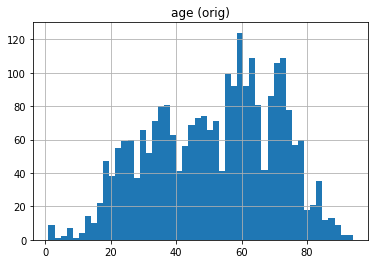

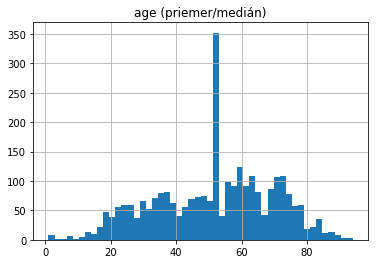

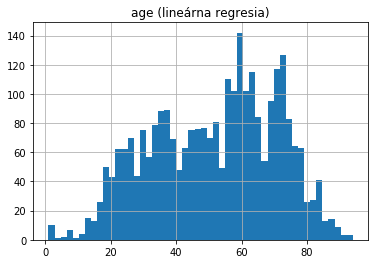

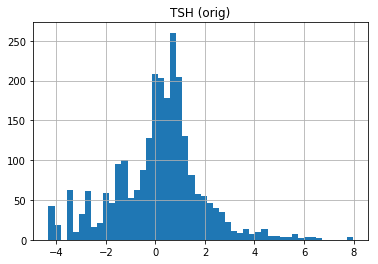

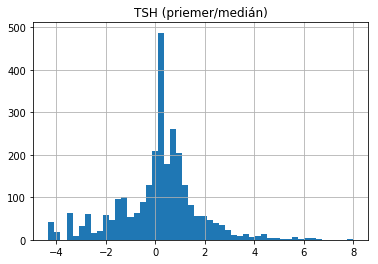

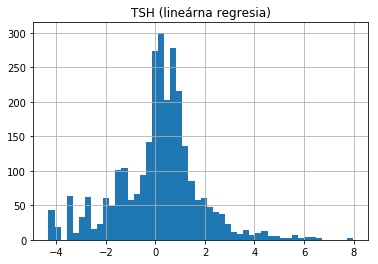

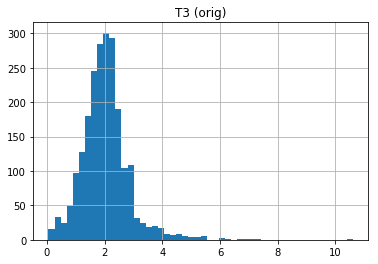

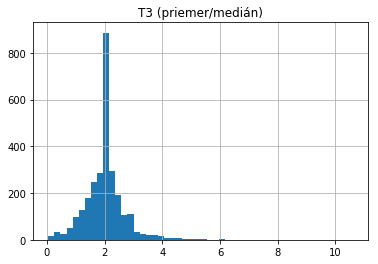

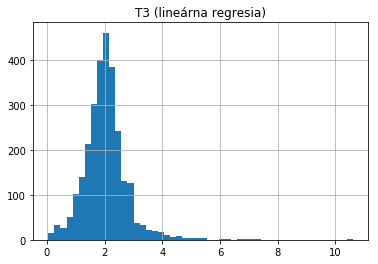

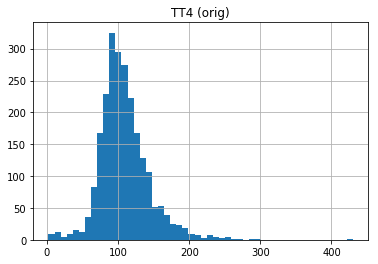

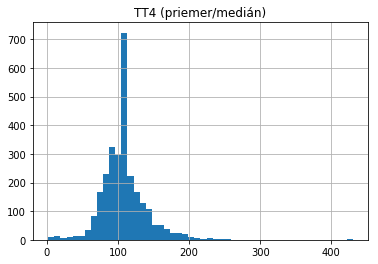

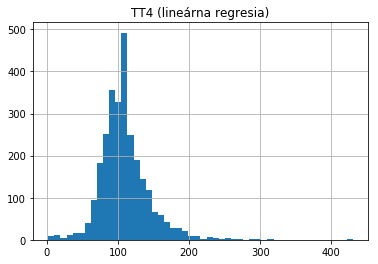

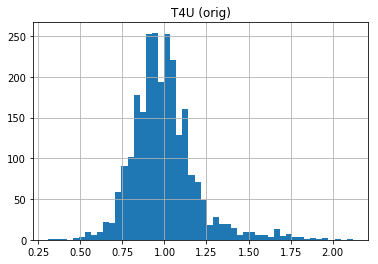

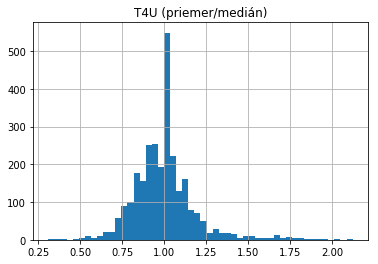

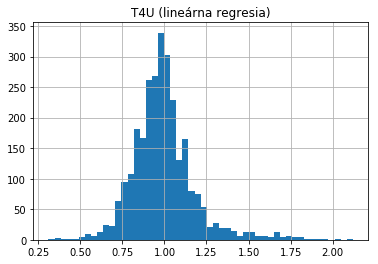

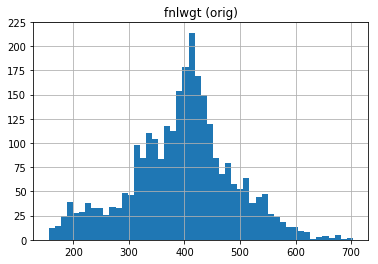

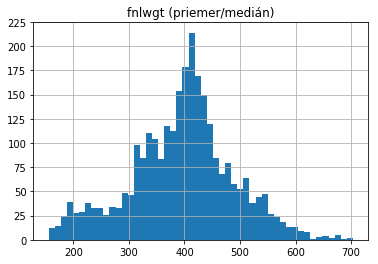

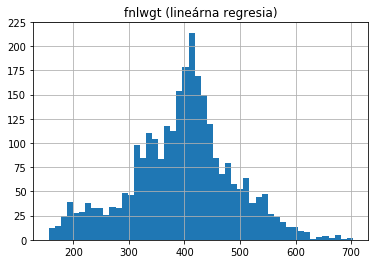

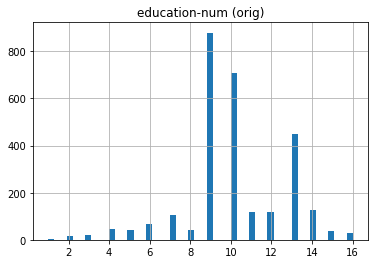

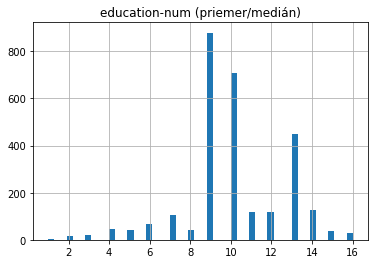

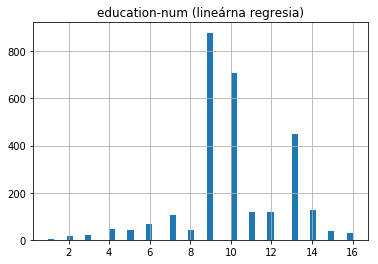

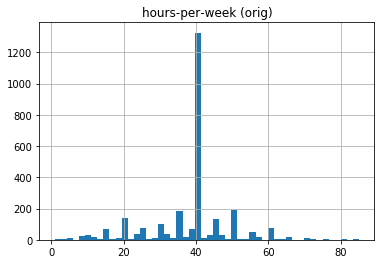

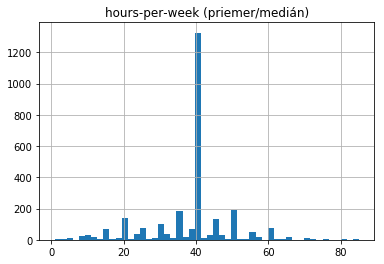

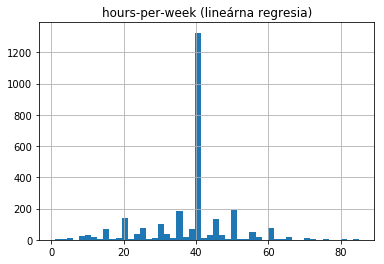

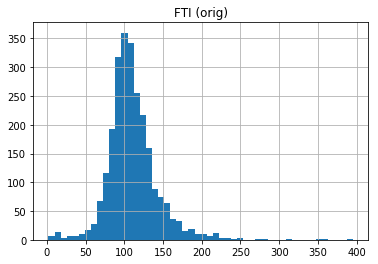

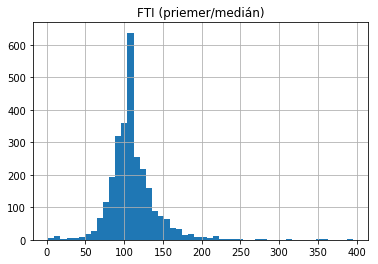

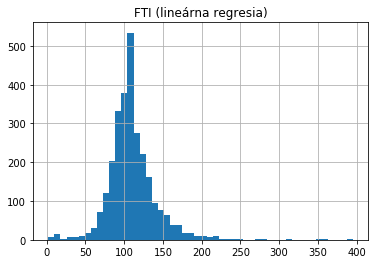

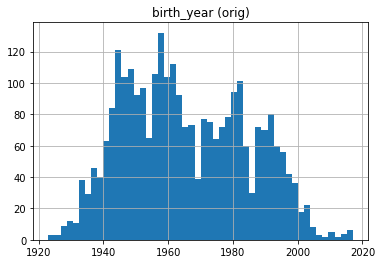

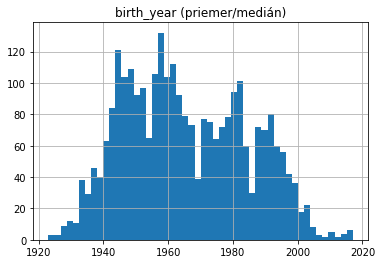

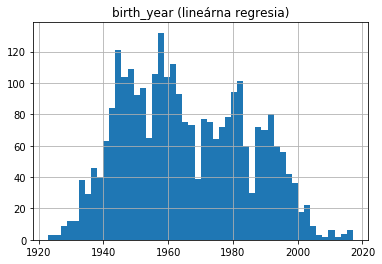

In [43]:
for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        mn, mx= train_data[col].min(), train_data[col].max()
        pd.Series(train_data[col]).hist(bins=50, range=(mn, mx)).set_title(col + " (orig)")
        plt.figure()
        pd.Series(mean_med[col]).hist(bins=50, range=(mn, mx)).set_title(col + " (priemer/medián)")
        plt.figure()
        pd.Series(linreg[col]).hist(bins=50, range=(mn, mx)).set_title(col + " (lineárna regresia)")
        plt.figure()

Čo sa týka deskriptívnych mierok, tak minimá a maximá atribútov boli zachované pri oboch metódach. Pri atribútoch vek, T3, TT4 a T4U, FTI rok a mesiac narodenia priemer/medián zachoval priemer atribútu, v prípade TSH ho posunul o dve jednotky, avšak vždy v týchto znížil štandardnú odchýľku, čo sa dalo očakávať, keďže viac hodnôt je koncentrovaných uprostred distribúcie. Medián sa pri priemere/mediáne zachoval pri TSH, čo naznačuje, že pri TSH sa použilo nahradzovanie mediánom a nie priemerom. Sústredenie viacerých hodnôt doprostred distribúcie atribútov malo za následok aj to, že sa v prípade atribútov vek, TSH, T3, TT4, T4U a FTI zmenšilo medzikvaritovlé rozpätie a až na TSH sa posunul medián.

Lineárna regresia pri atribútoch vek, TSH, T3, TT4, T4U, FTI rok a mesiac narodenia zmenila priemer a štandardnú odchýľku atribútov, pričom pri veku, mesiaci a roku narodenia ju zvyšovala, pri TSH, T3, TT4, T4U a FTI ju znižovala. Pri veku bolo medzikvaritlové rozpätie a medián zachované, pri ostatných, ak sa zmenilo, tak sa zužovalo. Medián bol zachovaný ešte aj pri T3 a mesiaci a roku narodenia.

In [44]:
train_data.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year
count,2519.000000,2516.000000,2215.000000,2352.000000,2503.000000,2800.000000,2800.000000,2800.000000,2505.000000,2793.000000
mean,51.634776,0.124040,2.024966,108.990391,0.997912,395.250981,10.080714,38.172339,110.787984,1965.513068
std,18.903753,1.770825,0.824600,35.622745,0.194390,93.543804,2.432641,11.315947,32.883986,18.916569
min,1.000000,-4.321335,0.050000,2.000000,0.310000,155.276000,1.000000,1.000000,2.000000,1923.000000
25%,36.000000,-0.794684,1.600000,88.000000,0.880000,338.579230,9.000000,35.000000,93.000000,1950.000000
50%,54.000000,0.341027,2.000000,104.000000,0.980000,402.288698,10.000000,40.000000,107.000000,1963.000000
75%,67.000000,0.992857,2.400000,125.000000,1.080000,447.824789,12.000000,40.000000,124.000000,1981.000000
max,94.000000,7.970062,10.600000,430.000000,2.120000,703.319089,16.000000,85.000000,395.000000,2017.000000


In [45]:
mean_med.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,51.634776,0.146049,2.024966,108.990391,0.997912,395.250981,10.080714,38.172339,110.787984,1965.514286
std,17.929758,1.679863,0.733383,32.647674,0.183788,93.543804,2.432641,11.315947,31.102848,18.892916
min,1.000000,-4.321335,0.050000,2.000000,0.310000,155.276000,1.000000,1.000000,2.000000,1923.000000
25%,38.000000,-0.504593,1.700000,91.000000,0.890000,338.579230,9.000000,35.000000,95.000000,1950.000000
50%,51.634776,0.341027,2.024966,108.990391,0.997912,402.288698,10.000000,40.000000,110.000000,1963.000000
75%,65.000000,0.906752,2.300000,120.000000,1.070000,447.824789,12.000000,40.000000,122.000000,1981.000000
max,94.000000,7.970062,10.600000,430.000000,2.120000,703.319089,16.000000,85.000000,395.000000,2017.000000


In [46]:
linreg.describe()

,age,TSH,T3,TT4,T4U,fnlwgt,education-num,hours-per-week,FTI,birth_year
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,51.696680,0.127688,2.034885,109.145312,0.995185,395.250981,10.080714,38.172339,110.438189,1965.530714
std,18.954868,1.698347,0.762587,34.246540,0.190885,93.543804,2.432641,11.315947,31.696822,18.938472
min,1.000000,-4.371956,0.050000,2.000000,0.122074,155.276000,1.000000,1.000000,2.000000,1923.000000
25%,36.000000,-0.665144,1.600000,89.000000,0.880000,338.579230,9.000000,35.000000,94.000000,1950.000000
50%,54.000000,0.265128,2.000000,107.000000,0.990000,402.288698,10.000000,40.000000,108.000000,1963.000000
75%,67.000000,0.924518,2.302075,123.000000,1.070000,447.824789,12.000000,40.000000,122.000000,1981.000000
max,94.000000,7.970062,10.600000,430.000000,2.120000,703.319089,16.000000,85.000000,395.000000,2017.000000


Korelácie medzi vekom a T3, TSH a T3, T3 a T4U, T3 a rokom narodenia sa pri oboch metódach znižovali, pri lineárnej regresii viac ako pri priemere/mediáne.

Korelácie medzi vekom a rokom narodenia, TSH a TT4, TSH a FTI, T3 a TT4, T3 a FTI lepšie zachovala lineárna regresia, priemer/medián ju narušil a znížil o 5 percent.

Korelácie medzi TT4 a T4U, TT4 a FTI sa pri metóde priemeru/mediánu znižovali, pri lineárnej regresii zvyšovali, menej sa vychýlila pritom lienárna regresia.

In [47]:
for i in range(train_data.shape[1]):
    if np.issubdtype(train_data[train_data.columns[i]].dtype, np.number):
        for i2 in range(i, train_data.shape[1]):
            if np.issubdtype(train_data[train_data.columns[i2]].dtype, np.number):
                corr = train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and train_data.columns[i] != train_data.columns[i2]:
                    print(train_data.columns[i], "-", train_data.columns[i2], " correlation: ", train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]]))

age - T3  correlation:  -0.26830163198714446
age - birth_year  correlation:  -0.9997542996642313
TSH - T3  correlation:  -0.31807469887551226
TSH - TT4  correlation:  -0.4457643114340478
TSH - FTI  correlation:  -0.5175766755548099
T3 - TT4  correlation:  0.5660571765652239
T3 - T4U  correlation:  0.46343405909602275
T3 - FTI  correlation:  0.3510133883173405
T3 - birth_year  correlation:  0.2686637335777969
TT4 - T4U  correlation:  0.4339389434445414
TT4 - FTI  correlation:  0.798007458309882


In [48]:
for i in range(mean_med.shape[1]):
    if np.issubdtype(mean_med[mean_med.columns[i]].dtype, np.number):
        for i2 in range(i, mean_med.shape[1]):
            if np.issubdtype(mean_med[mean_med.columns[i2]].dtype, np.number):
                corr = mean_med[mean_med.columns[i]].corr(mean_med[mean_med.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and mean_med.columns[i] != mean_med.columns[i2]:
                    print(mean_med.columns[i], "-", mean_med.columns[i2], " correlation: ", mean_med[mean_med.columns[i]].corr(mean_med[mean_med.columns[i2]]))

age - T3  correlation:  -0.227330804431043
age - birth_year  correlation:  -0.9428729603963131
TSH - T3  correlation:  -0.2824584252547181
TSH - TT4  correlation:  -0.4076004430889365
TSH - FTI  correlation:  -0.491088965761994
T3 - TT4  correlation:  0.49427897434188856
T3 - T4U  correlation:  0.421284351818439
T3 - FTI  correlation:  0.31144164682364106
T3 - birth_year  correlation:  0.23774312243471335
TT4 - T4U  correlation:  0.40388588092642685
TT4 - FTI  correlation:  0.7423305678200679


In [49]:
for i in range(linreg.shape[1]):
    if np.issubdtype(linreg[linreg.columns[i]].dtype, np.number):
        for i2 in range(i, linreg.shape[1]):
            if np.issubdtype(linreg[linreg.columns[i2]].dtype, np.number):
                corr = linreg[linreg.columns[i]].corr(linreg[linreg.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and linreg.columns[i] != linreg.columns[i2]:
                    print(linreg.columns[i], "-", linreg.columns[i2], " correlation: ", linreg[linreg.columns[i]].corr(linreg[linreg.columns[i2]]))

age - T3  correlation:  -0.2742298726616116
age - birth_year  correlation:  -0.9997799605153846
TSH - T3  correlation:  -0.32657587689256323
TSH - TT4  correlation:  -0.4422070655819654
TSH - FTI  correlation:  -0.5191187523282508
T3 - TT4  correlation:  0.5896731883942156
T3 - T4U  correlation:  0.4559209215815006
T3 - FTI  correlation:  0.36365710348717417
T3 - birth_year  correlation:  0.27425060521946176
TT4 - T4U  correlation:  0.4589535831586097
TT4 - FTI  correlation:  0.805247048477286


Naším cieľom pri rozhodovaní, ktorú z metód odhadovania neznámych hodnôt použijime pre dané atribúty bolo predovšetkým čo najlepšie zachovanie pôvodnej distribúcie daných atribútov, pretože sme predpokladali, že ak neznáme hodnoty atribútov predstavujú len istú vzorku z tohto dátového súboru, mala by byť distribúcia hodnôt a všetky výnimočnosti dátového súboru zachovávané aj v tejto menšej mierke približne v rovnakom tvare a zastúpení. Toto sme stavali samozrejme na predpoklade, že sa nejednalo o dáta, ktoré nosili oproti pôvodnému dátovému súboru isté špecifiká.

Každopádne rozhodli sme sa použiť stratégie nahradzovania neznámych hodnôt následovne: pri atribútoch vek, TT4, T4U, FTI a roku narodenia, kde lineárna regresia dosahovala vysokú presnosť použijeme lineárnu regresiu, pre ostatné použijeme priemer/medián, keďže sa nám zdá v prípade mylne odhadnutej chýbajúcej honoty menej deštruktívne ju nahradiť priemerom či mediánom, ako ju umiestniť na nejaké špecifické miesto v distribúcii daného atribútu a tým aj túto distribúciu potencionálne ovplyvniť.

Netvrdíme, že takýto postup bude bezchybný, alebo dokonca ten najlepší, aký sa núka, a preto si ponecháme dátové súbory s oboma stratégiami pre prípadné neskoršie overenie, ktoré nahradzovanie bolo pre klasifikáciu skutočne najlepšie.

In [50]:
raw_data = train_data.copy()

for col in train_data.columns:
    if np.issubdtype(train_data[col].dtype, np.number):
        if scores[col] > 0.75:
            train_data[col] = linreg[col]
        else:
            train_data[col] = mean_med[col]

## 3.2 Kategorické atribúty

Chýbajúce hodnoty kategorických atribútov sme sa rozhodli nahradzovať pomocou algoritmu k-najbližších susedov. Alternatívou k tomuto prístupu by mohlo byť náhodné doplnenie na základe početnosti výskytu jednotlivých hodnôt pre daný kategorický atribút, ale je zrejmé, že takáto stratégia by nebola optimálna, pretože by nebrala v úvahu prípadné prepojenia medzi niektorými atribútmi (napríklad by mohol pre tehotný subjekt doplniť, že je mužom).

Ešte pred realizáciou samotného algoritmu vymeníme všetky otázniky v kategorických atribútoch značiace neznáme hodnoty za NaN hodnoty, ktoré vie rozoznať knižnica pandas.

In [51]:
for col in train_data.columns[train_data.dtypes == np.object]:
    for i in range(train_data.shape[0]):
        if train_data.loc[i, col] == '?':
            train_data.loc[i, col] = np.nan

Keďže algoritmus KNN vie pracovať len s číslami, musíme najprv zakódovať hodnoty kategorických atribútov do číselných hodnôt. Robíme to technikou One Hot Encoding, pretože nevieme významovo usporiadať hodnoty kategorických stĺpcov a teda mierka vzdialenosti medzi nimi, pomocou ktorej pracuje KNN by bola chybná.

Použitím OHE ale vzniknú dva problémy. Jednak pre niektoré atribúty, ktoré nadobúdajú väčšie množstvo hodnôt vznikne rovnako veľa stĺpcov, čo spomaľuje samotný výpočet. Iste, toto by sa dalo odstrániť zlúčením viacerých unikátnych hodnôt do jednej, predovšetkým tých, ktoré sú menej časté (napríklad do hodnoty "ostatné"), ale pomalosť sme boli ochototní strpieť. Druhý problém je však ten, že nie je pri OHE zaručené, že NaN hodnoty budú nahradené. Binárne stĺpce vyjadrujúce hodnoty, ktoré môže istý atribút nadobúdať totiž nie sú prepojené v tom zmysle, že pri každej predikcii niektorý z nich nadobudne hodnotu 1, značiacu že atribút nadobúda práve hodnotu, ktorý vyjadruje zakódovaný stĺpec. Preto je nutné viackrát iterovať KNN algoritmus cez dátový súbor, optimálne s odlišnou vzorkou pre trénovanie KNN a počtom susedov, aby sa predišlo zaseknutiu algoritmu. Preeto sme nechali počet susedov s každou iteráciou znižovať. Uvedomujeme si, že existujú lepšie prístupy, ale pokiaľ nám takáto stratégia dokáže nahradiť všetky NaN hodnoty, je nateraz pre nás aj z časových dôvodov postačujúca.

In [52]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

knr = train_data.copy()

i = 0
while knr[knr.columns[knr.dtypes == np.object]].isnull().values.any() and i < int(math.sqrt(X.shape[0])) - 1:
    allNumeric = pd.get_dummies(knr, columns=knr.columns[knr.dtypes == np.object], dummy_na=True)

    NanColumns = []
    for col in allNumeric.columns[11:]:
        if '_nan' in col:
            NanColumns.append(col)

    for col in train_data.columns[train_data.dtypes == np.object]:

        X = allNumeric.copy()
        X = X.drop(NanColumns, axis=1)
        
        valcols = []
        nancol = ''
        for col2 in allNumeric.columns[11:]:
            if col2[:len(col)] == col:
                if '_nan' not in col2:
                    valcols.append(col2)
                else:
                    nancol = col2

        X = X.drop(valcols, axis=1)
        if (allNumeric[nancol] == 0).all():
            continue

        print(col, "Ostava NaN: ", allNumeric[allNumeric[nancol] == 1].shape[0])

        for currcol in valcols:
            y = allNumeric[currcol].copy()
            
            scaler = StandardScaler()
            scaler.fit(X)
            
            X = pd.DataFrame(scaler.transform(X), columns=X.columns)
            
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
            clf = neighbors.KNeighborsClassifier(int(math.sqrt(X.shape[0])) - i, weights='uniform')
            clf.fit(X_train, y_train)

            Q = allNumeric[allNumeric[nancol] == 1].drop(NanColumns, axis=1).drop(valcols, axis=1)
            Q = pd.DataFrame(scaler.transform(Q), columns=Q.columns)
            
            y = clf.predict(Q)
            
            #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými podla najblizsich susedov
            i2 = 0
            for i3 in range(knr.shape[0]):
                if (pd.isna(knr.loc[i3, col])):
                    if y[i2] != 0:
                        knr.loc[i3, col] = currcol[len(col)+1:]
                    i2 = i2 + 1
                    
    i = i + 1

workclass Ostava NaN:  169
occupation Ostava NaN:  169
native-country Ostava NaN:  60
sex Ostava NaN:  110
birth_month Ostava NaN:  7
workclass Ostava NaN:  26
occupation Ostava NaN:  110
sex Ostava NaN:  41
birth_month Ostava NaN:  7
occupation Ostava NaN:  3
sex Ostava NaN:  39
birth_month Ostava NaN:  7
sex Ostava NaN:  38
birth_month Ostava NaN:  7
sex Ostava NaN:  38
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  37
birth_month Ostava NaN:  7
sex Ostava NaN:  22
birth_month Ostava NaN:  7
sex Ostava NaN:  22
birth_month Ostava NaN:  7
sex Ostava NaN:  16
birth_month Ostava NaN:  7
sex Ostava NaN:  16
birth_month Ostava NaN:  7
sex Ostava NaN:  6
birth_month Ostava NaN:  7
sex Ostava NaN:  6
birth_month Osta

Aj napriek všetkému úsiliu nedokázalo KNN nahradiť všetky neznáme hodnoty. Nazdávame sa, že okrem iného by táto nerozhodnosť KNN mohla byť príčinou aj príliš rovnomernej distribúcie hodnôt, aké tieto atribúty, ktorým ešte ostávajú doplniť hodnoty majú. Takto nám neostáva iné, ako na doplnenie zvyšných chýbajúcich hodnôt použiť KNN tým spôsobom, ktorý nepovažujeme za celkom valídny.

Vytvorili sme si prekladač, ktorý jednoducho transformuje kategorické hodnoty na čísla a späť.

In [53]:
translator = {}
translatorRev = {}

for col in train_data.columns[train_data.dtypes == np.object]:
    translator[col] = {}
    translatorRev[col] = {}
    un = train_data[col].unique()
    for i in range(len(un)):
        translator[col][un[i]] = i
        translatorRev[col][i] = un[i]

def translateToNumeric(data, attr):
    trans = data[attr].copy()
    for i in range(len(trans)):
        if (pd.notna(trans[i])):
            trans[i] = translator[attr][trans[i]]
        
    return trans

def translateFromNumeric(val, attr):
    return translatorRev[attr][val]

Nechcali sme preložiť hodnoty všetkých kategorických atribútov na čísla.

In [54]:
allNumeric = train_data.copy()
for col in train_data.columns[train_data.dtypes == np.object]:
    allNumeric[col] = translateToNumeric(train_data, col)

A následne sme ešte raz použili KNN na doplnenie neznámych hodnôt. Iterovať už netreba, keďže hodnoty atribútov sa nerozvíjajú do binárnych stĺpcov, ale sú len transformované na čísla v pôvodnom stĺpci. Toto zaručuje, že sa všetky neznáme hodnoty doplnia.

In [55]:
from sklearn import neighbors

for col in train_data.columns[train_data.dtypes == np.object]:
    X = allNumeric.copy()
    
    NanColumns = []
    for col2 in X.columns:
         if X[pd.isna(X[col2])].shape[0] > 0 and col != col2:
            NanColumns.append(col2)
    
    X = X.dropna()
    X = X.drop(NanColumns, axis=1)
    
    y = X[col].copy().astype('int')
    X = X.drop(col, axis=1)
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
         
    clf = neighbors.KNeighborsClassifier(20, weights='uniform')
    clf.fit(X_train, y_train)
    print("Presnosť pre", col, ":", clf.score(X_test, y_test))
         
    clf.fit(X, y)
        
    notknown = allNumeric.copy()
    notknown = notknown[pd.isna(notknown[col])]
    if (notknown.shape[0] == 0):
            continue
      
    X = notknown.drop(NanColumns, axis=1)
    y = notknown[col]
    X = X.drop(col, axis=1)
                   
    y = clf.predict(X)
         
    #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými lineárnou regresiou
    i2 = 0
    for i in range(knr.shape[0]):
        if (pd.isna(knr.loc[i, col])):
            knr.loc[i, col] = translateFromNumeric(y[i2], col)
            i2 = i2 + 1

Presnosť pre on thyroxine : 0.8927125506072875
Presnosť pre query on thyroxine : 0.9979757085020243
Presnosť pre pregnant : 0.9838056680161943
Presnosť pre thyroid surgery : 0.9858299595141701
Presnosť pre I131 treatment : 0.9858299595141701
Presnosť pre lithium : 0.9939271255060729
Presnosť pre goitre : 0.9878542510121457
Presnosť pre tumor : 0.9655870445344129
Presnosť pre hypopituitary : 1.0
Presnosť pre T3 measured : 0.7631578947368421
Presnosť pre FTI measured : 0.8967611336032388
Presnosť pre referral source : 0.6032388663967612
Presnosť pre workclass : 0.7408906882591093
Presnosť pre marital-status : 0.41700404858299595
Presnosť pre occupation : 0.16396761133603238
Presnosť pre relationship : 0.2894736842105263
Presnosť pre race : 0.8380566801619433
Presnosť pre native-country : 0.9149797570850202
Presnosť pre TSH measured : 0.9008097165991903
Presnosť pre sex : 0.6781376518218624
Presnosť pre query hyperthyroid : 0.9453441295546559
Presnosť pre TT4 measured : 0.9149797570850202

Keďže nemáme žiadnú rozumnejšiu stratégiu, s ktorou by sme nahradzovanie pomocou KNN konfrontovali, výsledok sme rovno presunuli do pôvodného dátového súboru.

In [56]:
train_data = knr

Overili sme si, či sme naozaj odstránili všetky neznáme hodnoty.

In [57]:
for column in train_data.columns:
    b = train_data[column].isnull()
    c = b[b == True].count()
    if c != 0:
        print(column, ": ", c)

   # 4 Prieskumná analýza

Po úprave dátového súboru sa vzťahy medzi dvojicami číselných a kategorických atribútov upravili následovne:
Zoslabené vzťahy:
- TSH a query on thyroxine
- TSH a pregnant
- TSH a workclass
- fnlwgt a marital_status
- fnlwgt a race
- TSH a TT4 measured
- TSH a T4U measured
- TSH a test

Posilnené vzťahy:
- TSH a thyroid surgery
- TSH a l131 treatment
- lithium a birth month
- TT4 a referal_source

Je možné si povšimnúť, že transformácia TSH na box-cox a prípadne aj dopĺňanie neznámych hodnôt mali značný vplyv na tento atribút, predovšetkým skrz zoslabenie mnohých vzťahov TSH s inými kategorickými atribútmi. Menší, ale stále badateľný vplyv mala box-cox transformácia aj na fnlwgt. Odhadovaním bol ovplyvnení aj vzťah TT4 a referal_source.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


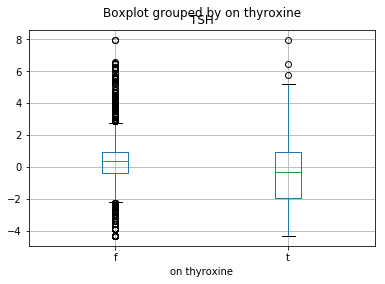

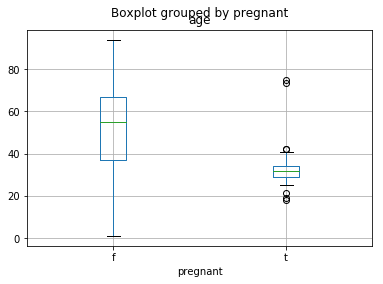

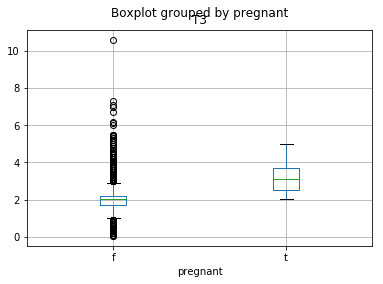

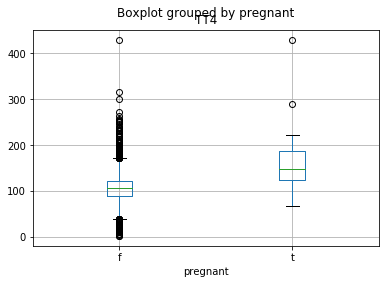

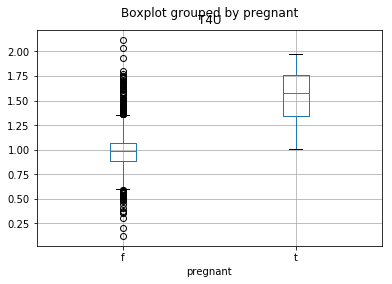

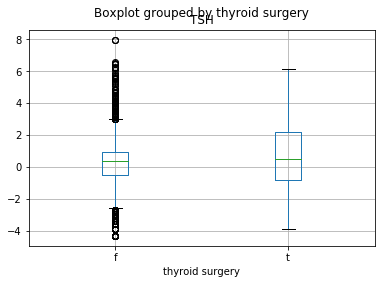

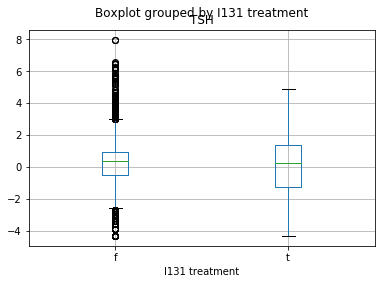

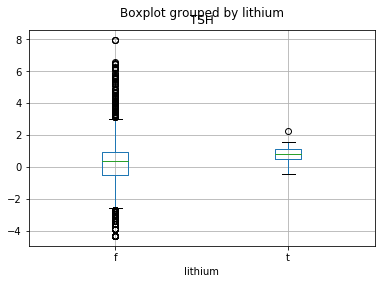

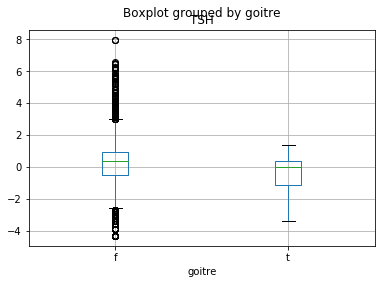

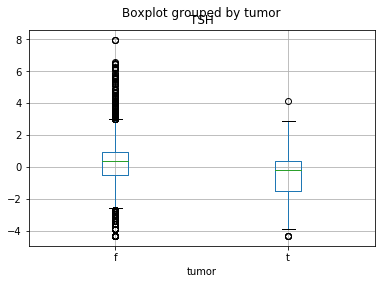

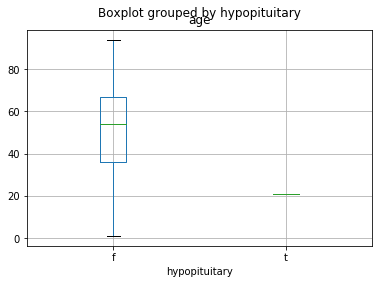

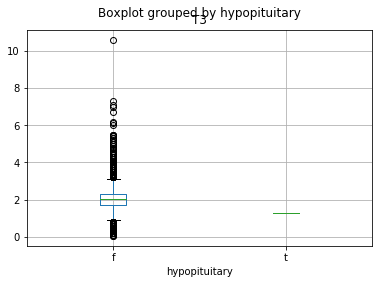

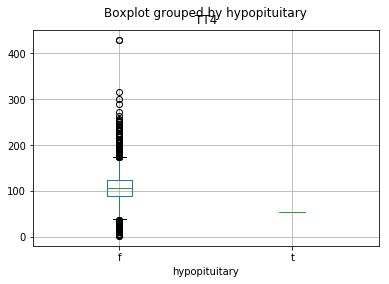

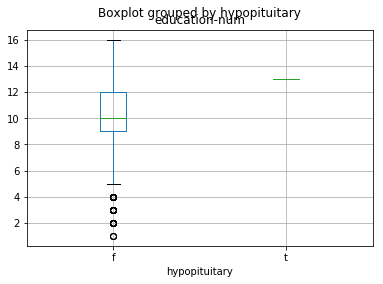

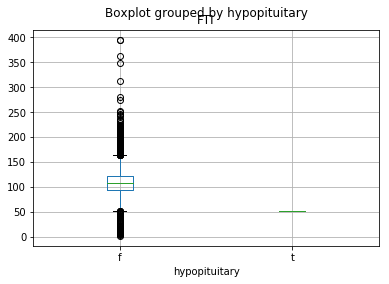

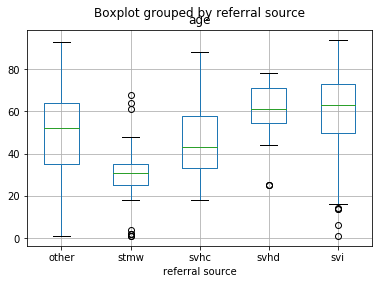

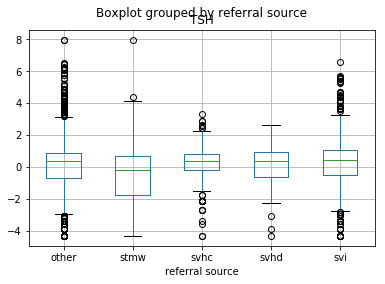

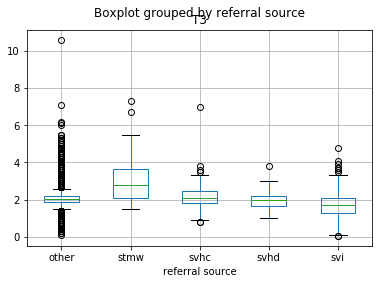

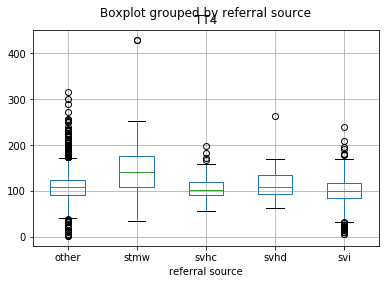

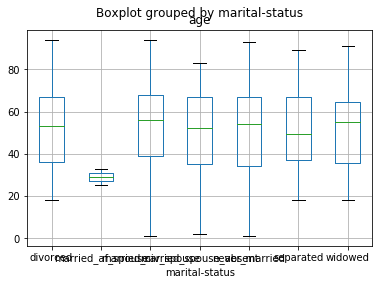

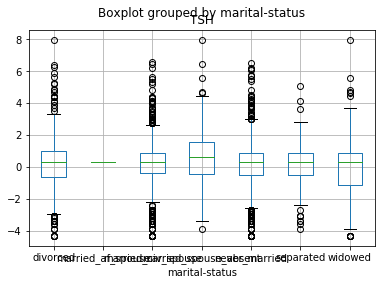

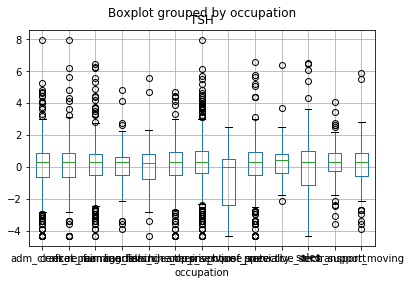

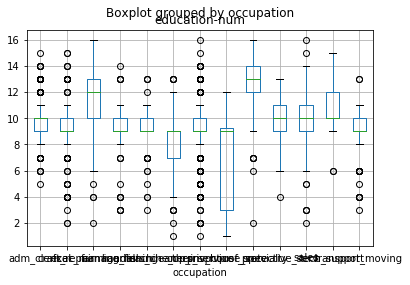

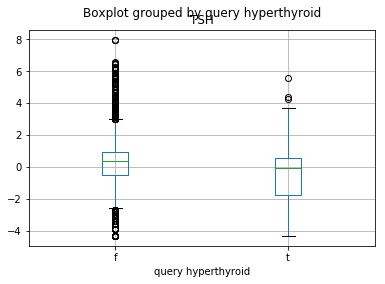

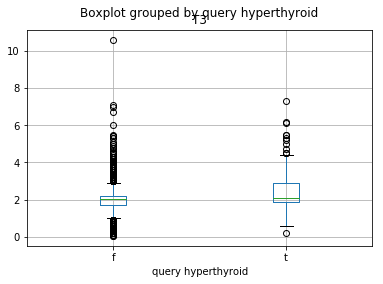

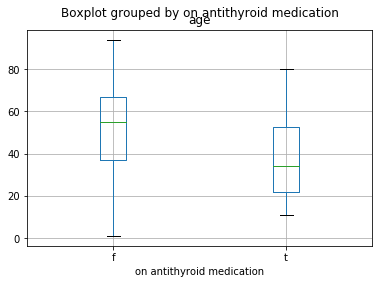

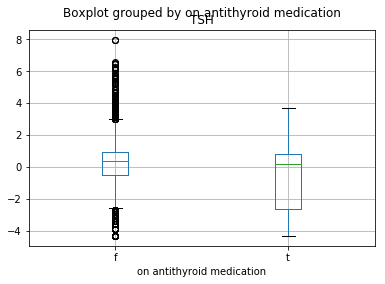

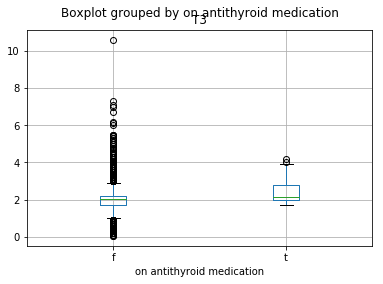

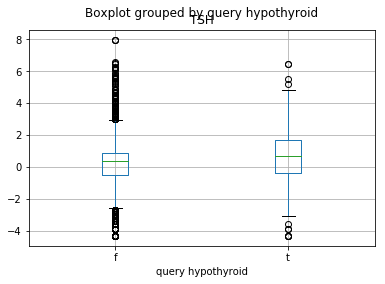

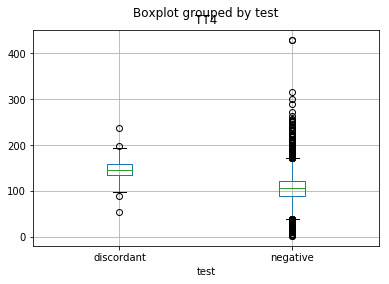

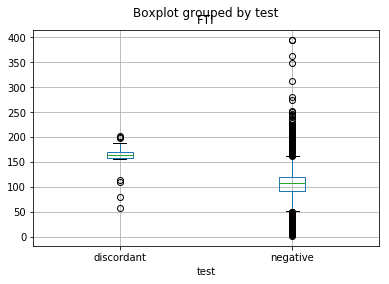

In [58]:
for column in train_data.columns[train_data.dtypes == np.object]:
    for column2 in train_data.columns:
        if np.issubdtype(train_data[column2].dtype, np.number) and column != column2 and train_data[column].unique().size < 35:
            if train_data[column2].std() / train_data[column2].mean() <= 1:
                means = train_data.groupby(column).mean()[[column2]]
                if means[column2].std() / means[column2].mean() > 0.15:
                    train_data.boxplot(column=column2,by=column)
            else:
                medians = train_data.groupby(column).median()[[column2]]
                if medians[column2].mean() != 0 and medians[column2].std() / medians[column2].mean() > 0.15:
                    train_data.boxplot(column=column2,by=column)

I keď algoritmus nezistil žiadne vzťahy medzi novými, pridanými atribútmi a kategorickými atribptmi, predsa sa pozrieme, aké majú tieto novovzniknuté atribúty vzťahy.

Pri roku narodenia možno bádať isté výkyvy, predovšetkým pri referral source, marital-status, occupation a native-country. Nepatrnejšie sú už pri sick, alebo psych.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


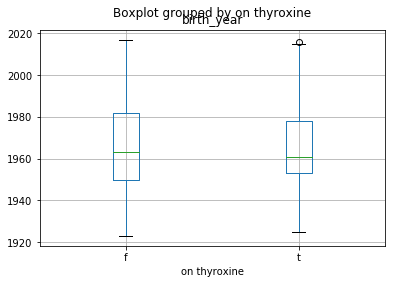

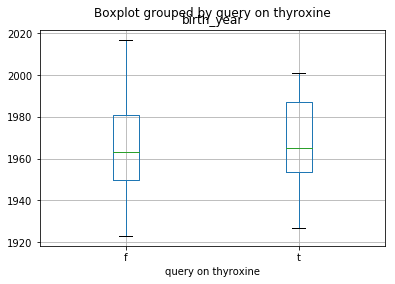

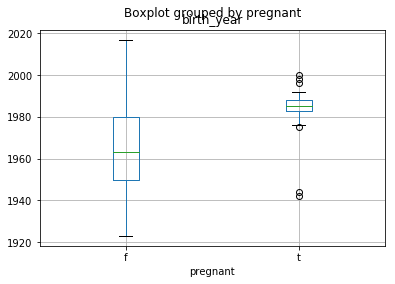

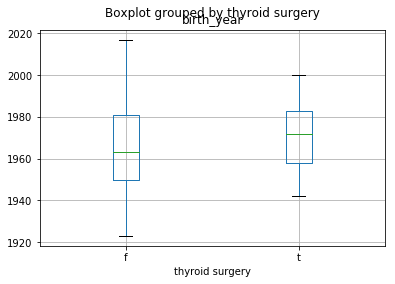

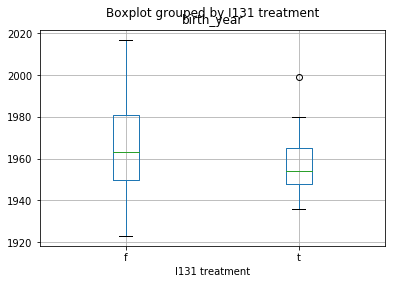

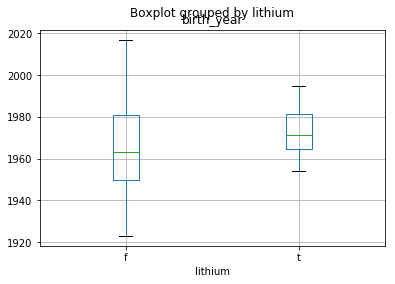

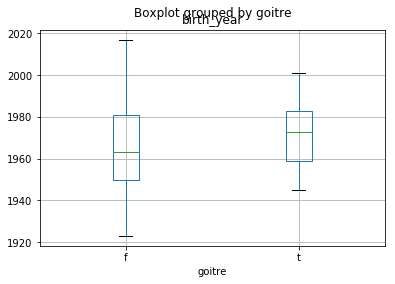

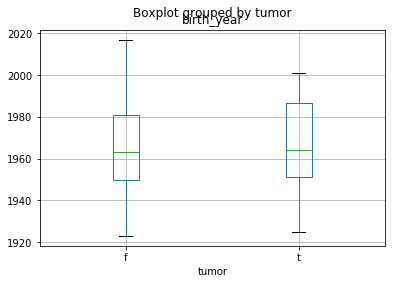

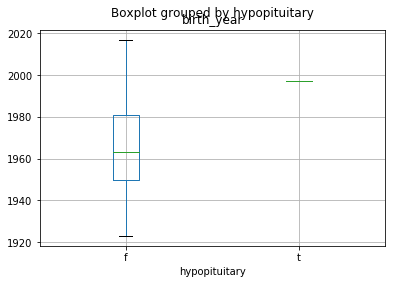

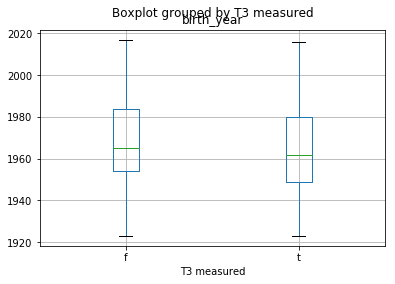

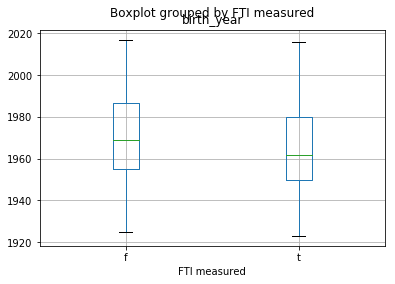

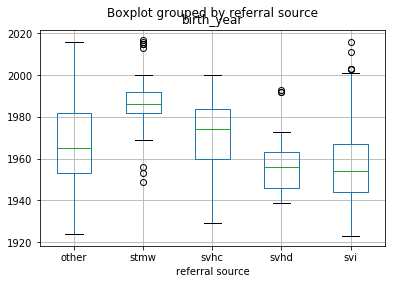

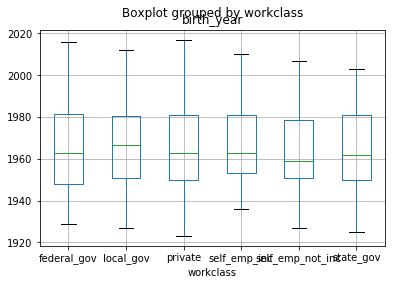

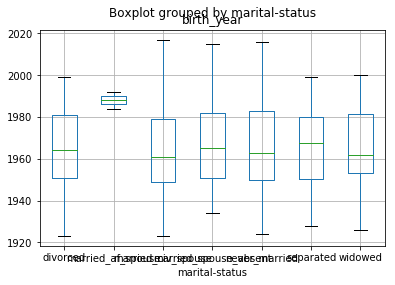

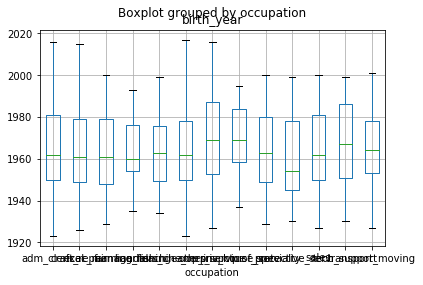

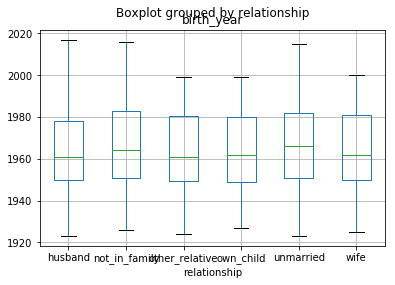

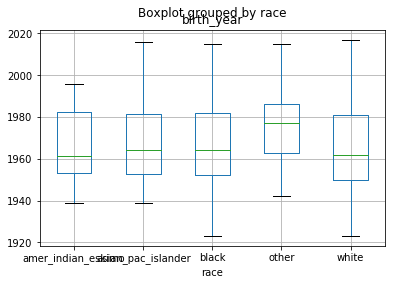

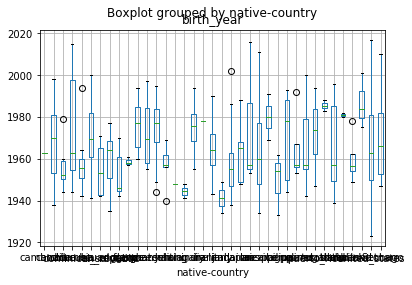

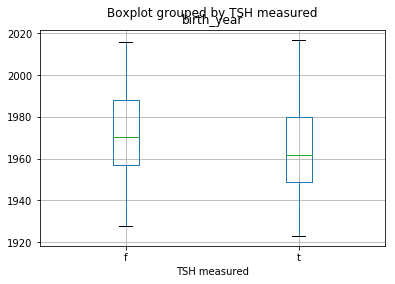

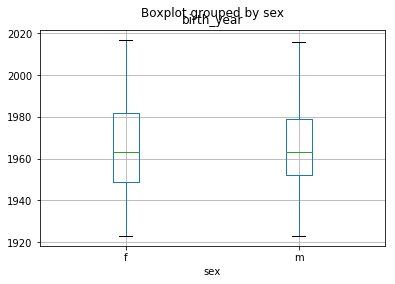

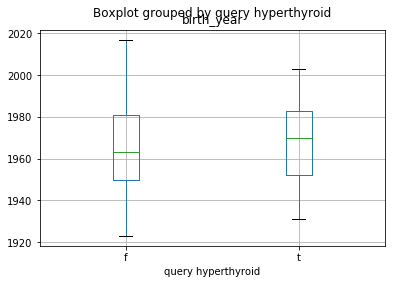

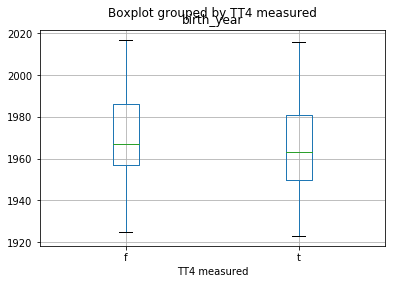

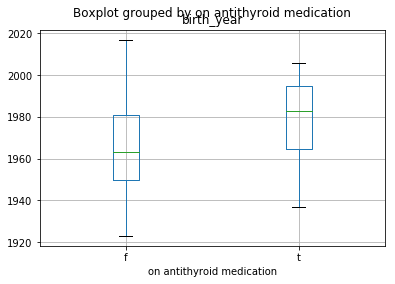

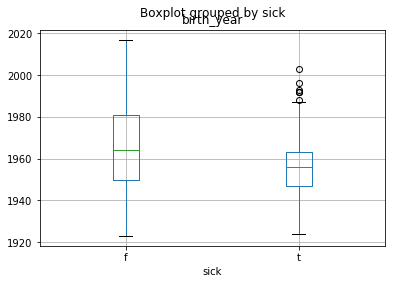

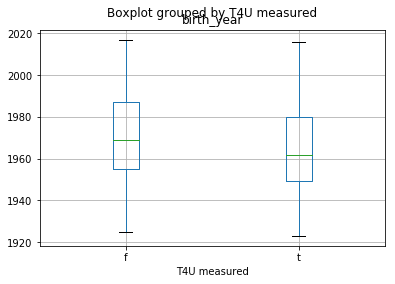

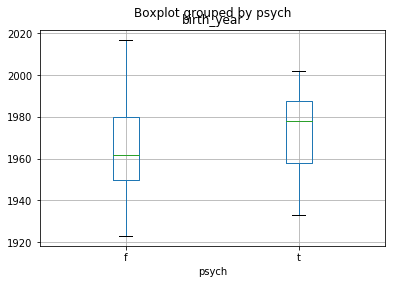

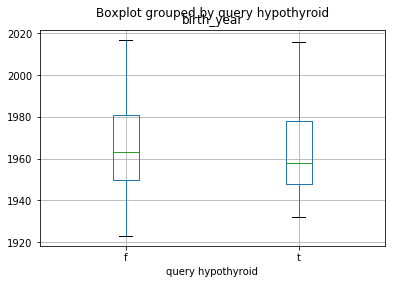

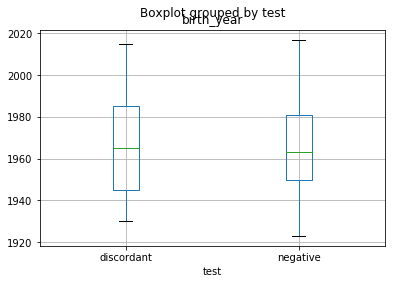

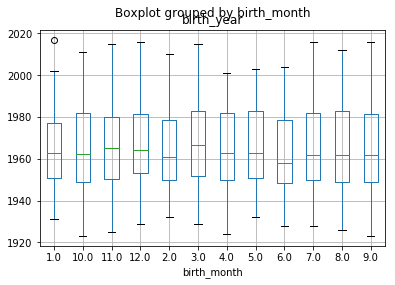

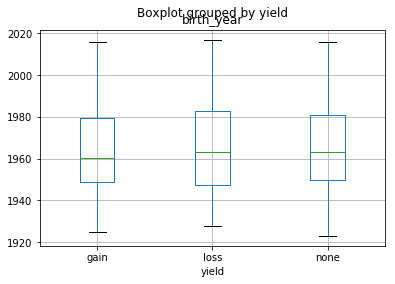

In [59]:
for column in train_data.columns[train_data.dtypes == np.object]:
    train_data.boxplot(column='birth_year',by=column)

Pri odlišných mesiacoch narodenia sú len zanedbateľné výkyvy medzi hodnotami číselných atribútov. Bezpečne možno povedať, že mesiac narodenia žiaden z číselných atribútov neovplyvňuje.

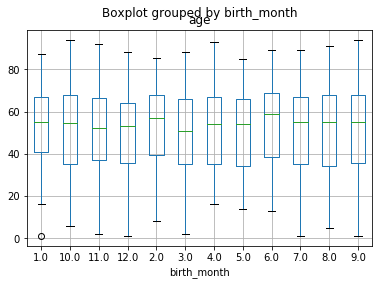

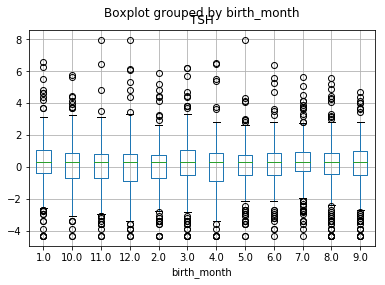

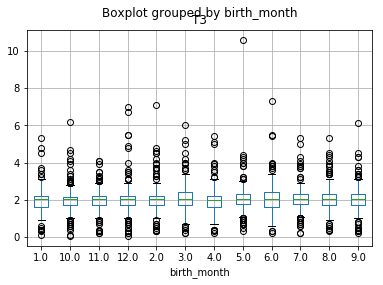

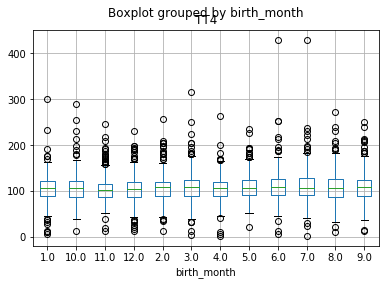

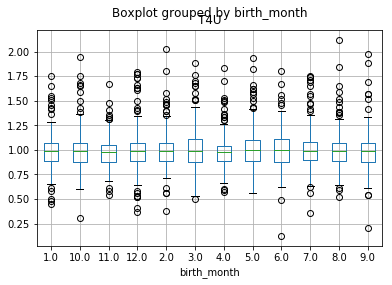

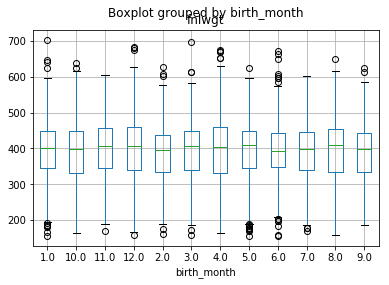

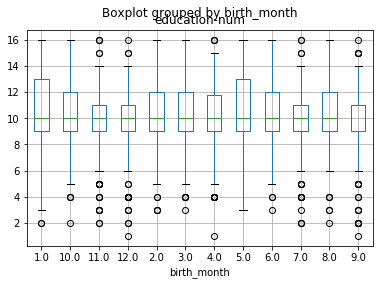

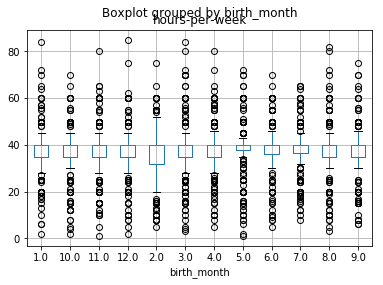

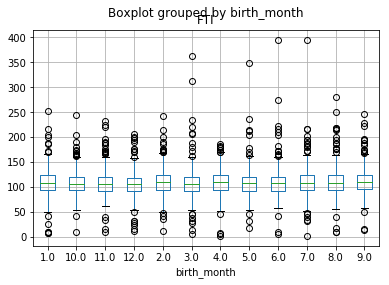

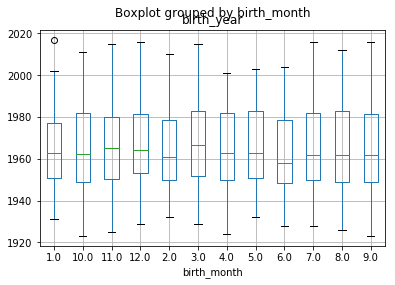

In [60]:
for column in train_data.columns:
    if np.issubdtype(train_data[column].dtype, np.number):
        train_data.boxplot(column=column,by='birth_month')

Ani pri odlišnej výške zisku sa nemenili hodnoty atribútov.

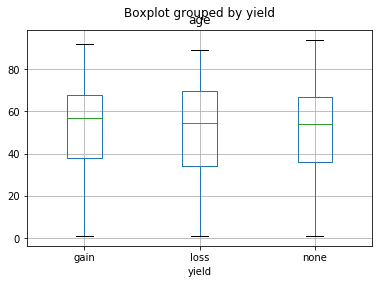

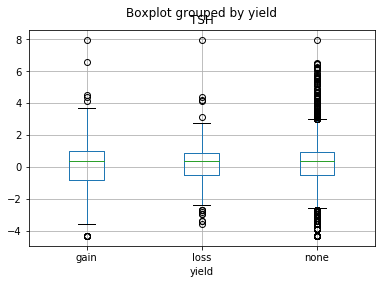

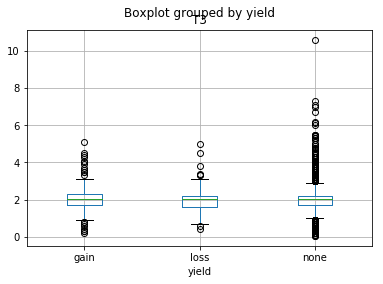

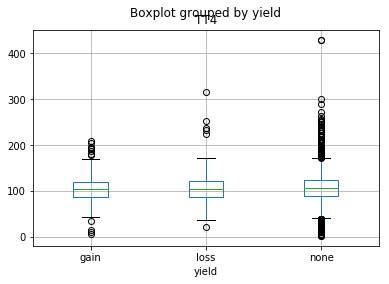

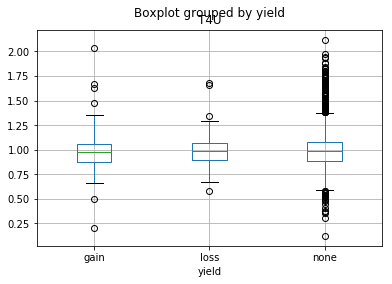

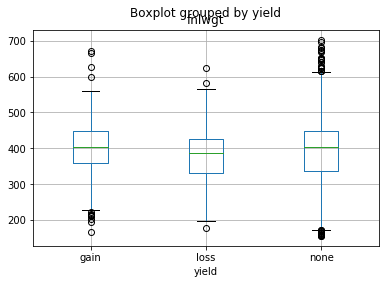

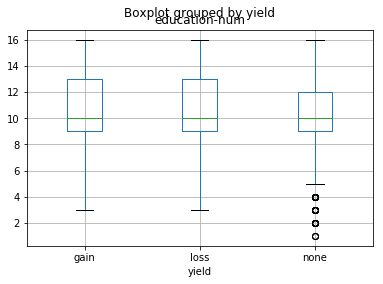

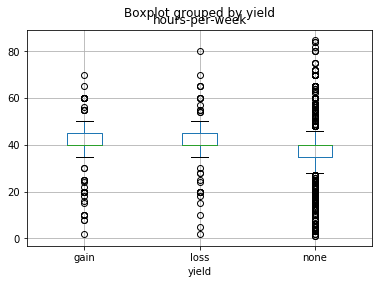

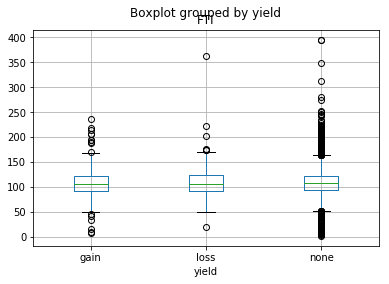

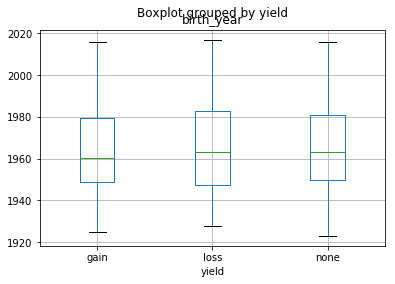

In [61]:
for column in train_data.columns:
    if np.issubdtype(train_data[column].dtype, np.number):
        train_data.boxplot(column=column,by='yield')

Pozreli sme sa aj na vzťahy dvojíc kategorických atribútov, ale pri nich nedošlo pri žiadnej k jednoznačne interpretovateľnej zmene.

Čo sa týka korelácie dvojíc číselných atribútov, tak taktiež došlo k niekoľkým zmenám. Pribudla takmer dokonalá korelácia medzi vekom a dátumom narodenia, ako by sa dalo aj očakávať. Taktiež pribudla korelácia medzi dátumom narodenia a T3, pričom sa jedná taktmer o rovnakú koreláciu ako medzi vekom a T3 - keďže vek a dátum narodenia sú tak silno korelované. Prah 20 percent prekročila aj ďalšia nová záporná korelácia medzi TSH a T3, táto však ostáva pomerne slabá (-28). Korelácie medzi TSH a TT4 a TSH a FTI výrazne zosilneli, na čom má nepochybne výrazný podiel transformácia na box-cox. Korelácie medzi T3 a TT4, T3 a T4U, T3 a FTI zoslabili, každá približne o päť percent, čo môže byť v dôsledku odhadovania neznámaych hodnôt T3 pomocou priemeru/mediánu. Korelácie medzi TT4 a T4U, TT4 a FTI zosilnili o bezmála jedno percento.

age - T3  correlation:  -0.23762883455109998
age - birth_year  correlation:  -0.9997799605153846
TSH - T3  correlation:  -0.2824584252547181
TSH - TT4  correlation:  -0.4286532617159857
TSH - FTI  correlation:  -0.5006112547956559
T3 - TT4  correlation:  0.51575139262461
T3 - T4U  correlation:  0.4149349735111674
T3 - FTI  correlation:  0.31014958527287234
T3 - birth_year  correlation:  0.23756544799200635
TT4 - T4U  correlation:  0.4589535831586097
TT4 - FTI  correlation:  0.805247048477286


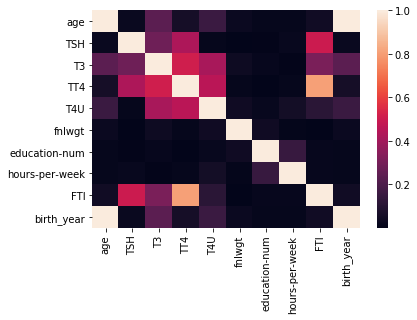

In [62]:
for i in range(train_data.shape[1]):
    if np.issubdtype(train_data[train_data.columns[i]].dtype, np.number):
        for i2 in range(i, train_data.shape[1]):
            if np.issubdtype(train_data[train_data.columns[i2]].dtype, np.number):
                corr = train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]])
                if (corr > 0.2 or corr < -0.2) and train_data.columns[i] != train_data.columns[i2]:
                    print(train_data.columns[i], "-", train_data.columns[i2], " correlation: ", train_data[train_data.columns[i]].corr(train_data[train_data.columns[i2]]))

corr = train_data.corr()
seaborn.heatmap(abs(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Zdá sa, že ani jeden z pridaných atribútov nie je pre klasifikáciu potrebný, avšak chceme sa vyhnúť predčasným záverom a tak aj tieto nové atribúty ponecháme. Napokon, ak nemajú na klasifikáciu vplyv, ich prítomnosť môže uškodiť jedine v zmysle výkonnosti/rýchlosti klasifikácie.

Týmto skončila naša práca na predspracovaní. Dátový súbor by mal byť už plne pripravený pre klasifikáciu bez nutnosti dodatočných úprav.

# 5 Pravidlá

V bunke nižšie sme si načítali skript, do ktorého sme zahrnuli všetky úpravy, ktoré sme nad dátovým súborom vykonali. Pomocou neho budeme môcť vykonať rovanké úpravy aj nad testovacím súborom.

In [63]:
# %load predspracovanie_skript.py
import pandas as pd
import numpy as np
import random as rnd
import seaborn
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import re

from scipy.stats import boxcox
from functools import reduce

def replaceWithBC(data, attr):
    bc, att = boxcox(data[attr].dropna())
    i2 = 0
    for i in range(data.shape[0]):
        if pd.notna(data.loc[i, attr]):
            data.loc[i, attr] = bc[i2]
            i2 = i2 + 1
    data.rename(index=str, columns={attr: attr + "_(box_cox)"})
            
def replaceOutliers(data, attr, thrshl, new):
    for i in range(data.shape[0]):
        if thrshl(data.loc[i, attr]):
            data.loc[i, attr] = new
            
def replaceOutliersD(data, attr, thrshl, new):
    for i in range(data.shape[0]):
        if thrshl(data.loc[i, attr]):
            data.loc[i, attr] = new(data.loc[i])


def preprocess(filepath):
    #1 nacitanie
    print('1 nacitanie')
    train_data = pd.DataFrame()
    train_data = pd.read_csv(filepath)

    #2 nahradenie indexu
    print('2 nahradenie indexu')
    train_data = train_data.set_index('Unnamed: 0')
    train_data.index.names = ['id']

    #3 rozvinutie stplcov
    print('3 rozvinutie stplcov')
    import json
    raw = train_data.loc[1, 'medical_info']
    raw = raw.replace("'", '"')
    data = json.loads(raw)

    #pridanie stlpcov
    for k in data.keys():
        train_data[k] = np.nan

    #naplnenie zaznamov hodnotami z medical_info
    for i in range(train_data.shape[0]):
        raw = train_data['medical_info'][i]
        raw = raw.replace("'", '"')
        data = json.loads(raw)
        for att in data.keys():
            train_data.loc[i, att] = data[att]
        
    #odstranenie nepotrebneho stlpca
    train_data = train_data.drop(columns=['medical_info'])

    #4 ciselne FTI
    print('4 ciselne FTI')
    train_data['FTI'] = pd.to_numeric(train_data['FTI'], errors='coerce')

    #5 ciselne TBG
    print('5 ciselne TBG')
    train_data['TBG'] = pd.to_numeric(train_data['TBG'], errors='coerce')
    
    train_data['TT4'] = pd.to_numeric(train_data['TT4'], errors='coerce')

    #6 rozvinutie vysledku testu
    print('6 rozvinutie vysledku testu')
    for i in range(train_data.shape[0]):
        train_data.loc[i, 'test'], train_data.loc[i, 'testID'] = str(train_data['class'][i]).split(".|")

    train_data = train_data.drop(columns=['class'])

    #7 zahodenie nepotrebnych stlpcov
    print('7 zahodenie nepotrebnych stlpcov')
    train_data = train_data.drop(['TBG measured', 'TBG', 'education', 'testID'], axis=1)

    #8 rozvinutie datumu narodenia
    print('8 rozvinutie datumu narodenia')
    train_data['birth_year'] = np.nan
    train_data['birth_month'] = np.nan
    
    for i in range(train_data.shape[0]-1):
        if (pd.isna(train_data.loc[i]['date_of_birth'])):
            continue
        date = list(map(int, re.split(' |-|/|:', train_data.iloc[i]['date_of_birth'])))
        if date[0] <= 31 and date[2] <= 31:
            continue
        elif date[0] <= 31 and date[2] > 31:
            b = date[2]
            date[2] = date[0]
            date[0] = b
        if date[0] < 1900:
            if int(str(date[0])[-2:]) < 18:
                date[0] = date[0] + 2000 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
            else:
                date[0] = date[0] + 1900 - int(str(date[0])[:-2] if str(date[0])[:-2] != '' else 0) * 100
        if len(date) > 3:
            date = date[:3]
        train_data.loc[i, 'birth_year'] = date[0]
        train_data.loc[i, 'birth_month'] = date[1]

    train_data['birth_month'] = train_data['birth_month'].astype(str)
    for i in range(train_data.shape[0]):
        if train_data.loc[i,'birth_month'] == 'nan':
            train_data.loc[i,'birth_month'] = '?'
            
    #9 zlucenie hodnot
    print('9 zlucenie hodnot')
    for i in range(train_data.shape[0]):
        if train_data.loc[i, 'on thyroxine'] == 'FALSE' or train_data.loc[i, 'on thyroxine'] == 'F':
            train_data.loc[i, 'on thyroxine'] = 'f'
        elif train_data.loc[i, 'on thyroxine'] == 'TRUE' or train_data.loc[i, 'on thyroxine'] == 'T':
            train_data.loc[i, 'on thyroxine'] = 't'
        
        for col in train_data.columns[train_data.dtypes == np.object]:
            if pd.notna(train_data.loc[i, col]):
                train_data.loc[i, col] = train_data.loc[i, col].lower().strip().replace("-", "_")
        
    #10 nahrada za box-cox
    print('10 nahrada za box-cox')
    replaceWithBC(train_data, 'TSH')
    replaceWithBC(train_data, 'fnlwgt')

    #11 odstranenie odlahlych hodnot
    print('11 odstranenie odlahlych hodnot')
    replaceOutliers(train_data, 'fnlwgt', lambda a: a > 720, np.percentile(train_data['fnlwgt'], 95))
    replaceOutliers(train_data, 'hours-per-week', lambda a: a > 95, np.percentile(train_data['hours-per-week'], 95))
    replaceOutliersD(train_data, 'age', lambda a: a > 100, lambda a: 2017 - a.birth_year)
    
    #12 zlucenie education-num
    print('12 zlucenie education-num')
    for i in range(len(train_data['education-num'])):
        if train_data.loc[i, 'education-num'] < 0:
            train_data.loc[i, 'education-num'] *= -1
        if train_data.loc[i, 'education-num'] >= 100:
            train_data.loc[i, 'education-num'] = train_data.loc[i, 'education-num']/100
        
    #13 kategorizacia kapitalu
    print('13 kategorizacia kapitalu')
    train_data['yield'] = np.nan
    for i in range(train_data.shape[0]):
        yld = train_data.loc[i,'capital-gain'] - train_data.loc[i, 'capital-loss']
        if (yld == 0):
            train_data.loc[i, 'yield'] = 'none'
        elif (yld < 0):
            train_data.loc[i, 'yield'] = 'loss'
        else:
            train_data.loc[i, 'yield'] = 'gain'

    train_data = train_data.drop(['capital-gain', 'capital-loss'], axis=1)

    #14 nahradzovanie priemerom
    print('14 nahradzovanie priemerom')
    import math

    mean_med = train_data.copy()

    for column in mean_med.columns:
        if np.issubdtype(mean_med[column].dtype, np.number):
            if mean_med[column].std() / mean_med[column].mean() <= 1:
                mean = mean_med[column].mean()
                for i in range(len(mean_med[column])):
                    if (np.isnan(mean_med.loc[i, column])):
                        mean_med.loc[i, column] = mean
            else:
                median = mean_med[column].median()
                for i in range(len(mean_med[column])):
                    if (np.isnan(mean_med.loc[i, column])):
                        mean_med.loc[i, column] = median

    for i in range(mean_med.shape[0]):
        mean_med.loc[i, 'birth_year'] = math.ceil(mean_med.loc[i, 'birth_year'])
       
    #15 nahradzovanie regresiou
    print('15 nahradzovanie regresiou')
    import sklearn.linear_model
    import sklearn.model_selection

    linreg = train_data.copy()
    numericOnly = pd.DataFrame()
    scores = {}

    for col in train_data.columns:
        if np.issubdtype(train_data[col].dtype, np.number):
            numericOnly[col] = train_data[col].dropna()

    for col in train_data.columns:
        if np.issubdtype(train_data[col].dtype, np.number):
            numericOnly = numericOnly.dropna()
            X = numericOnly
            y = numericOnly[col]
            X = X.drop(col, axis=1)
            
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
            
            reg = sklearn.linear_model.LinearRegression()
            reg.fit(X_train, y_train)
            print("Presnosť pre", col, ":", reg.score(X_test, y_test))
            
            scores[col] = reg.score(X_test, y_test)
            
            notknown = pd.DataFrame()
            for col2 in train_data.columns:
                if np.issubdtype(train_data[col2].dtype, np.number):
                    #kvôli neznámym hodnotam v necieľových stĺpcoch musíme použiť odhad neznámych dohnôt priemerom/mediánom
                    notknown[col2] = mean_med[col2]
                if col2 == col:
                    #iba pre cieľový stĺpec vyberáme dáta z pôvodného súboru, kde sú stále aj neznáme hodnoty
                    notknown[col2] = train_data[col2]
            
            notknown = notknown[pd.isna(notknown[col])]
            if (notknown.shape[0] == 0):
                continue
                
            X = notknown
            y = notknown[col]
            X = X.drop(col, axis=1)
                    
            y = reg.predict(X)
            
            #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými lineárnou regresiou
            i2 = 0
            for i in range(linreg.shape[0]):
                if (pd.isna(linreg.loc[i, col])):
                    linreg.loc[i, col] = y[i2]
                    i2 = i2 + 1

    for i in range(mean_med.shape[0]):
        linreg.loc[i, 'birth_year'] = math.ceil(linreg.loc[i, 'birth_year'])

    #16 nahradenie priemerom/medianom a regresiou
    print('16 nahradenie priemerom/medianom a regresiou')
    raw_data = train_data.copy()

    for col in train_data.columns:
        if np.issubdtype(train_data[col].dtype, np.number):
            if scores[col] > 0.75:
                train_data[col] = linreg[col]
            else:
                train_data[col] = mean_med[col]

    #17 nahradenie ? za NaN
    print('17 nahradenie ? za NaN')
    for col in train_data.columns[train_data.dtypes == np.object]:
        for i in range(train_data.shape[0]):
            if train_data.loc[i, col] == '?':
                train_data.loc[i, col] = np.nan

    import random
    
    #18 nahradzovanie KNN
    print('18 nahradzovanie KNN')
    from sklearn import neighbors
    from sklearn.preprocessing import StandardScaler

    knr = train_data.copy()

    i = 0
    while knr[knr.columns[knr.dtypes == np.object]].isnull().values.any() and i < int(math.sqrt(X.shape[0])) - 1:
        allNumeric = pd.get_dummies(knr, columns=knr.columns[knr.dtypes == np.object], dummy_na=True)

        NanColumns = []
        for col in allNumeric.columns[11:]:
            if '_nan' in col:
                NanColumns.append(col)

        for col in train_data.columns[train_data.dtypes == np.object]:

            X = allNumeric.copy()
            X = X.drop(NanColumns, axis=1)
            
            valcols = []
            nancol = ''
            for col2 in allNumeric.columns[11:]:
                if col2[:len(col)] == col:
                    if '_nan' not in col2:
                        valcols.append(col2)
                    else:
                        nancol = col2

            X = X.drop(valcols, axis=1)
            if (allNumeric[nancol] == 0).all():
                continue

            print(col, "Ostava NaN: ", allNumeric[allNumeric[nancol] == 1].shape[0])

            for currcol in valcols:
                y = allNumeric[currcol].copy()
                
                scaler = StandardScaler()
                scaler.fit(X)
                
                X = pd.DataFrame(scaler.transform(X), columns=X.columns)
                
                X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
                clf = neighbors.KNeighborsClassifier(int(math.sqrt(X.shape[0])) - i, weights='uniform')
                clf.fit(X_train, y_train)

                Q = allNumeric[allNumeric[nancol] == 1].drop(NanColumns, axis=1).drop(valcols, axis=1)
                Q = pd.DataFrame(scaler.transform(Q), columns=Q.columns)
                
                y = clf.predict(Q)
                
                #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými podla najblizsich susedov
                i2 = 0
                for i3 in range(knr.shape[0]):
                    if (pd.isna(knr.loc[i3, col])):
                        if y[i2] != 0:
                            knr.loc[i3, col] = currcol[len(col)+1:]
                        i2 = i2 + 1
                        
        i = i + 1

    
    #19 nahradzovanie KNN
    print('19 druhe KNN')
    
    translator = {}
    translatorRev = {}

    for col in train_data.columns[train_data.dtypes == np.object]:
        translator[col] = {}
        translatorRev[col] = {}
        un = train_data[col].unique()
        for i in range(len(un)):
            translator[col][un[i]] = i
            translatorRev[col][i] = un[i]

    def translateToNumeric(data, attr):
        trans = data[attr].copy()
        for i in range(len(trans)):
            if (pd.notna(trans[i])):
                trans[i] = translator[attr][trans[i]]
            
        return trans

    def translateFromNumeric(val, attr):
        return translatorRev[attr][val]

    allNumeric = train_data.copy()
    for col in train_data.columns[train_data.dtypes == np.object]:
        allNumeric[col] = translateToNumeric(train_data, col)

    from sklearn import neighbors

    for col in train_data.columns[train_data.dtypes == np.object]:
        X = allNumeric.copy()
        
        NanColumns = []
        for col2 in X.columns:
             if X[pd.isna(X[col2])].shape[0] > 0 and col != col2:
                NanColumns.append(col2)
        
        X = X.dropna()
        X = X.drop(NanColumns, axis=1)
        
        y = X[col].copy().astype('int')
        X = X.drop(col, axis=1)
         
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
             
        clf = neighbors.KNeighborsClassifier(20, weights='uniform')
        clf.fit(X_train, y_train)
        print("Presnosť pre", col, ":", clf.score(X_test, y_test))
             
        clf.fit(X, y)
            
        notknown = allNumeric.copy()
        notknown = notknown[pd.isna(notknown[col])]
        if (notknown.shape[0] == 0):
                continue
          
        X = notknown.drop(NanColumns, axis=1)
        y = notknown[col]
        X = X.drop(col, axis=1)
                       
        y = clf.predict(X)
             
        #postupne dopĺňame neznáme hodnoty hodnotami odhadovanými lineárnou regresiou
        i2 = 0
        for i in range(knr.shape[0]):
            if (pd.isna(knr.loc[i, col])):
                knr.loc[i, col] = translateFromNumeric(y[i2], col)
                i2 = i2 + 1

    #20 koniec
    print('20 hotovo')
    train_data = knr

    return train_data


Načítame si testovacie dáta a vykonáme na ňom ekvivalentné úpravy, ako sme vykonávali nad trénovacími dátami.

In [64]:
test_data = preprocess('data/test.csv')

1 nacitanie
2 nahradenie indexu
3 rozvinutie stplcov
4 ciselne FTI
5 ciselne TBG
6 rozvinutie vysledku testu
7 zahodenie nepotrebnych stlpcov
8 rozvinutie datumu narodenia
9 zlucenie hodnot
10 nahrada za box-cox
11 odstranenie odlahlych hodnot
12 zlucenie education-num
13 kategorizacia kapitalu
14 nahradzovanie priemerom
15 nahradzovanie regresiou
Presnosť pre age : 0.9994907542675643
Presnosť pre TSH : 0.41014161818128514
Presnosť pre T3 : 0.35064707413257934
Presnosť pre TT4 : 0.9779254066471929
Presnosť pre T4U : 0.7758283278931674
Presnosť pre fnlwgt : -0.021097584568340766
Presnosť pre education-num : -0.016010219676427573
Presnosť pre hours-per-week : 0.0315083053884766
Presnosť pre FTI : 0.934449359329449
Presnosť pre birth_year : 0.9995128051799975
16 nahradenie priemerom/medianom a regresiou
17 nahradenie ? za NaN
18 nahradzovanie KNN
workclass Ostava NaN:  71
occupation Ostava NaN:  72
native-country Ostava NaN:  14
sex Ostava NaN:  40
birth_month Ostava NaN:  4
occupation Os

Pomocou bivariantnej analýzy, ktorú sme vykonali v časti prieskumnej analýzy sme vybrali niekoľko potencionálne zaujímavých pravidiel, ktoré si overíme ako na trénovacom, tak aj na testovacom dátovom súbore. Tieto pravidlá sú:
- hypopituitary: t => test: negative
- lithium: t => test: negative
- TT4 < 110 => test: negative
- FTI < 155 => test: negative
- TT4 < 110 ∧ FTI < 155 => test: negative
- age >= 40 ∧ relationship: unmarried => pregnant: f
- age >= 40 ∧ relationship: unmarried ∧ T3 < 2.1 ∧ TT4 < 120 ∧ T4U < 1.1 => pregnant: f

Nutno poznamenať, že tvar pravidiel je vyjadrený prostredníctvom implikácie a tak za nepravidvé je považované len v tom prípade, ak z pravidvého predpokladu vyplynie negovaný dôsledok. To znamená, že nie všetky štatistické mierky, ktoré na vyjadrovanie pravdivosti používame majú svoj zaužívaný význam.

Zadefinovali sme si triedu pravidlo, ktorá nam uľahčila ako vytváranie, tak aj vyhodnocovanie pravidiel.

In [65]:
class Pravidlo:
    def __init__(self):
        self.popis = ''
        self.podmienka = lambda a:True
        self.dosledok = lambda a:True
        
    def __init__(self, pop, pod, dos):
        self.popis = pop
        self.podmienka = pod
        self.dosledok = dos
        
    def over(self, data):
        total = data.shape[0]
        tp = data[self.podmienka(data) & self.dosledok(data)].shape[0]
        tIe = data[self.podmienka(data) & ~self.dosledok(data)].shape[0]
        tIIe = data[~self.podmienka(data) & self.dosledok(data)].shape[0]
        tn =data[~self.podmienka(data) & ~self.dosledok(data)].shape[0]
        
        print(64*'═')
        print('║{:<20}║{:<20}|{:<20}║'.format('', 'Prediction positive', 'Prediction negative'))
        print(64*'═')
        print('║{:<20}║{:<20.2f}|{:<20.2f}║'.format('Condition positive', tp, tIIe))
        print(64*'═')
        print('║{:<20}║{:<20.2f}|{:<20.2f}║'.format('Condition negative', tIe, tn))
        print(64*'═')
        
        print("Accuracy: ", (tp + tn) / total if total != 0 else 0)
        print("Precission: ",  tp / (tp + tIe) if tp + tIe != 0 else 0)
        print("Recall: ", tp / (tp + tIIe) if tp + tIIe != 0 else 0)

Príslušné pravidlá sme vyjadrili v tvare zrozumiteľnom pre počítač.

In [82]:
pravidla = []
pravidla.append(Pravidlo('hypopituitary: t => test: negative', lambda a: a.hypopituitary == 't', lambda a: a.test == 'negative'))
pravidla.append(Pravidlo('lithium: t => test: negative', lambda a: a.lithium == 't', lambda a: a.test == 'negative'))
pravidla.append(Pravidlo('TT4 < 110 => test: negative', lambda a: a.TT4 < 110, lambda a: a.test == 'negative'))
pravidla.append(Pravidlo('FTI < 155 => test: negative', lambda a: a.FTI < 155, lambda a: a.test == 'negative'))
pravidla.append(Pravidlo('TT4 < 110 ∧ FTI < 155 => test: negative', lambda a: (a.TT4 < 110) & (a.FTI < 155), lambda a: a.test == 'negative'))
pravidla.append(Pravidlo('age >= 40 ∧ relationship: unmarried => pregnant: f', lambda a: (a.age >= 40) & (a.relationship == 'unmarried'), lambda a: a.pregnant == 'f'))
pravidla.append(Pravidlo('age >= 40 ∧ relationship: unmarried ∧ T3 < 2.1 ∧ TT4 < 120 ∧ T4U < 1.1 => pregnant: f', lambda a: (a.age >= 40) & (a.relationship == 'unmarried') & (a.T3 < 2.1) &(a.TT4 < 120) & (a.T4U < 1.1), lambda a: a.pregnant == 'f'))

Otestovali sme si presnosť pravidiel ako na trénovacom súbore, podľa ktorých sme ich vytvárali tak aj na testovacom súbore.

Pri vyhodnocovaní budú pre nás zaujímvé predovšetkým hodnoty Precission a Recall (podpora) a hodnoty True Positive (koľko pravidlo správne predikovalo za pozitívne), False Positive (koľko pravidlo nesprávne predikovalo za pozitívne) a False Negative (koľko pozitívnych pravidlo opomenulo). False Negative zaujímavé pre nás nebude, pretože vyjadruje platnosť opaku pravidla, čo ale samotné pravidlo nezahŕňa, keďže nie je exkluzívne (napríklad hypopituitary: t => test: negative neznamená, že ak je hypopituitary == f, potom t == discordnant). Z toho dôvodu budeme venovať málo pozornosti aj Accuracy.

Prvé pravidlo, ktoré sme vymysleli hovorí, že ak má pozorovanie pravdivé hypotituitary, potom bol test pozorovania negatívny.
Ako je možné vidieť, toto pravidlo má len veľmi nízku podporu - v trénovacom súbore má hypotituitary pravdivé len jedno pozorovanie, ale to je zároveň dôvod, prečo sme si ho vybrali. Chceli sme zistiť, nakoľko toto pravidlo, ktoré síce je vždy platné v trénovacom súbore, ale má len zanedbateľnú podporu, čo sa týka početnosti výskytu, bude platné aj v testovacom súbore.

Bohužiaľ však pravidlo nemá v testovacom súbore žiadnú podporu (žiadne pozorovanie nemá hypotituitary pravdivé), takže testovací súbor pravdivosť pravidla nedokáže overiť.

In [90]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[0].popis)
print('Trénovací súbor: ')
pravidla[0].over(train_data)
print('\nTestovací súbor: ')
pravidla[0].over(test_data)

---------------------------------------------
Overovanie pravidla:  hypopituitary: t => test: negative
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║1.00                |2754.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║0.00                |45.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.016428571428571428
Precission:  1.0
Recall:  0.0003629764065335753

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║0.00                |959.00              ║
════════════════════════════════════════════════════════════════


Následujúce pravidlo vyjadrujúce, že poozorovanie s pravidvým lítiom má test negatívny má už podporu v oboch súboroch, i keď stále je pomerne mizivá. Každopádne je dostatočná, aby mse mohli povedať, že pre oba dátové súbory je toto pravidlo bezchybné, i keď pravda ako to predcházdajúce opomína mnoho pravdicých hodnôt.

In [89]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[1].popis)
print('Trénovací súbor: ')
pravidla[1].over(train_data)
print('\nTestovací súbor: ')
pravidla[1].over(test_data)

---------------------------------------------
Overovanie pravidla:  lithium: t => test: negative
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║14.00               |2741.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║0.00                |45.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.02107142857142857
Precission:  1.0
Recall:  0.005081669691470054

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║4.00                |955.00              ║
════════════════════════════════════════════════════════════════
║Conditi

Ďalšie pravidlo už pracuje s číselným atribútom. Vraví, že ak je namerané TT4 menšie ako 110, tak je test negatívny. Toto sme vypozorovali priamo z analýzy dvojíc číselných a kategorických atribútov. Pravidlo má značne lepšiu podporu ako tie pred ním, pričom si v och súboroch zachováva i veľmi vysokú presnosť.

In [88]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[2].popis)
print('Trénovací súbor: ')
pravidla[2].over(train_data)
print('\nTestovací súbor: ')
pravidla[2].over(test_data)

---------------------------------------------
Overovanie pravidla:  TT4 < 110 => test: negative
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║1648.00             |1107.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║3.00                |42.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.6035714285714285
Precission:  0.9981829194427619
Recall:  0.5981851179673321

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║582.00              |377.00              ║
══════════════════════════════════════════════════════════════

Ďalšie pravidlo tvrdí, že ak je namerané FTI menšie ako 155, tak je test negatívny. Podpora pravidla je už v porovnaní s predchádzajúcimi veľmi vysoká, takže zároveň má aj vysoká presnosť pravidla omnoho vyššiu váhu ako pri predchádzajúcich dvoch. Presnosť však pri testovacom súbore klesala.

In [87]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[3].popis)
print('Trénovací súbor: ')
pravidla[3].over(train_data)
print('\nTestovací súbor: ')
pravidla[3].over(test_data)

---------------------------------------------
Overovanie pravidla:  FTI < 155 => test: negative
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║2600.00             |155.00              ║
════════════════════════════════════════════════════════════════
║Condition negative  ║4.00                |41.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.9432142857142857
Precission:  0.9984639016897081
Recall:  0.9437386569872959

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║906.00              |53.00               ║
══════════════════════════════════════════════════════════════

Toto pravidlo sme vytvorili ako spojenie predchádzajúcich dvoch. Predpokladali sme, že takéto pravidlo bude prinajhoršom presnejšie, ako dve predchádzajúce pravidlá, pričom bude mať ale nižšiu podporu. Tak tomu aj bolo.

In [86]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[4].popis)
print('Trénovací súbor: ')
pravidla[4].over(train_data)
print('\nTestovací súbor: ')
pravidla[4].over(test_data)

---------------------------------------------
Overovanie pravidla:  TT4 < 110 ∧ FTI < 155 => test: negative
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║1641.00             |1114.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║3.00                |42.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.6010714285714286
Precission:  0.9981751824817519
Recall:  0.5956442831215971

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║580.00              |379.00              ║
══════════════════════════════════════════════════

Vyskúšali sme aj pravidlo kombinujúce kategorický a číselný atirbút. Toto vraví, že pozorovanie s vekom nad 40 rokov, ktoré nie je vydaté/oženené nie je tehotné. Pravidlo má podporu nižšiu, a síce pri trénovacom súbore nie je úplne pravdivé, pre trénovacom tomu už tak je.

In [84]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[5].popis)
print('Trénovací súbor: ')
pravidla[5].over(train_data)
print('\nTestovací súbor: ')
pravidla[5].over(test_data)

---------------------------------------------
Overovanie pravidla:  age >= 40 ∧ relationship: unmarried => pregnant: f
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║323.00              |2436.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║2.00                |39.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.12928571428571428
Precission:  0.9938461538461538
Recall:  0.1170714026821312

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║115.00              |845.00              ║
══════════════════════════════════════

Posledným pravidlom sme si chceli vyksúšať ešte navýšiť presnosť predchádzajúceho pravidla a taktiež kombináciu väčšieho počtu atribútov. Podarilo sa nám tak vytvoriť pomerne málo podporované pravidlo odhadujúce, kedy je pozrovanie tehotné ktoré je bezchybné u uboch testovacích súboroch.

In [85]:
print('---------------------------------------------\nOverovanie pravidla: ', pravidla[6].popis)
print('Trénovací súbor: ')
pravidla[6].over(train_data)
print('\nTestovací súbor: ')
pravidla[6].over(test_data)

---------------------------------------------
Overovanie pravidla:  age >= 40 ∧ relationship: unmarried ∧ T3 < 2.1 ∧ TT4 < 120 ∧ T4U < 1.1 => pregnant: f
Trénovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║146.00              |2613.00             ║
════════════════════════════════════════════════════════════════
║Condition negative  ║0.00                |41.00               ║
════════════════════════════════════════════════════════════════
Accuracy:  0.06678571428571428
Precission:  1.0
Recall:  0.052917723812975714

Testovací súbor: 
════════════════════════════════════════════════════════════════
║                    ║Prediction positive |Prediction negative ║
════════════════════════════════════════════════════════════════
║Condition positive  ║58.00               |902.00              ║
════════════════

# 6 Záver
V tejto časti projektu sa nám pomerne úspešne podarilo vhodnými úpravami adresovať všetky problémy, ktoré sme zistili v časti prieskumnej analýzy a zároveň aj odpovedať, na otázky, ktoré sme si na konci tej časti preložili. Spolu s čiastočným predspracovaním, ktoré sme vykonali už počas prieskumnej analýzy sme teda spolu vykonali všetky tieto zmeny:
- premenovali sme stĺpec Unnamed 0 (tento názov mu prisúdil program) na id použili sme ho ako index dátového súboru
- stĺpec medical_info, ktorý agregoval viaceré atribúty sme rozvinuli do viacerých stĺpcov, kde bol každý agregovaný atribút zvlášť, agregujúci stĺpec sme odstránili
- zistili sme, že atribúty FTI a TBG, ktoré vznikli po rozvinutí medical_info sú číselné a tak sme ich konvertovali na číselné atribúty
- atribút class, voči ktorému budeme klasifikovať sme rozbili do samostatných dvoch atribútov test (označuje výsledok testu, proti ktorému klasifikujeme teraz) a testID, pričom samotný class sme odstránili
- zahodili sme nepotrebné stĺpce TBG, TBG measured, education a testID
- extrhovali sme z atribútu birth_date, kde obli dátumy narodenia v odlišných formátoch mesiac a rok narodenia, ktoré sme dali do samostatných stĺpcov birth_year a birth_month
- zlúčili sme hodnoty atribútov s rovnakým významom (predovšetkym atirbúty on thyroxine, workclass)
- nahradili sme atribúty TSH a fnlwgt za ich box-cox transformácie pre zlepšenie ich distribúcie
- nahradili sme odľahlé hodnoty (fnlwgt, hours-per-week, age) za 95-percentný kvartil
- zlúčili sme hodnoty s rovnakým významom atribútu education-num
- atribúty capital-loss a capital-gain, ktoré mali podivné distribúcie sme zlúčili od kategorického atribútu yield, ktorý len vyjadaruje, či bol nejaký zisk, alebo strata, capital-loss a capital-gain sme odstránili
- pomocou priemeru, mediánu a lineárnej regresie sme odhadli neznáme hodnoty číselných atribútov
- a pomocou algoritmu k-najbližších susedov sme odhadli nenzáme hodnoty kategorických atribútov

Domnievame sa, že po vykonaní všetkých úprav sme úspešne ukončili predspracovanie súboru a môžeme ho tak aký ho na konci tejto časti prezentujeme využiť pre potreby klasifikácie.